#**Topic Modelling on the Complete Anglo-Saxon Poetry Corpus**

#**Set Up**

In [1]:
#Setting Up Folder Usage
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Computational Linguistics/Final Project

Mounted at /content/gdrive
/content/gdrive/MyDrive/Computational Linguistics/Final Project


In [2]:
#Necessary Packages
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import glob
from scipy.sparse import lil_matrix
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import defaultdict
import pickle
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

In [3]:
#URL Document Dictionary
web_corpus = 'https://sacred-texts.com/neu/ascp/'

r = requests.get(web_corpus)
source = r.text
soup = BeautifulSoup(source)

corpus_dict = {}

for element in soup.find_all('a')[3:]:
  try:
    title = element.get_text()
    link = element['href']
    corpus_dict[title] = 'https://sacred-texts.com/neu/ascp/' + link
  except:
    pass

corpus_dict

{'Genesis A, B': 'https://sacred-texts.com/neu/ascp/a01_01.htm',
 'Exodus': 'https://sacred-texts.com/neu/ascp/a01_02.htm',
 'Daniel': 'https://sacred-texts.com/neu/ascp/a01_03.htm',
 'Christ and Satan': 'https://sacred-texts.com/neu/ascp/a01_04.htm',
 'Andreas': 'https://sacred-texts.com/neu/ascp/a02_01.htm',
 'The Fates of the Apostles': 'https://sacred-texts.com/neu/ascp/a02_02.htm',
 'Soul and Body I': 'https://sacred-texts.com/neu/ascp/a02_03.htm',
 'Homiletic Fragment I': 'https://sacred-texts.com/neu/ascp/a02_04.htm',
 'Dream of the Rood': 'https://sacred-texts.com/neu/ascp/a02_05.htm',
 'Elene': 'https://sacred-texts.com/neu/ascp/a02_06.htm',
 'Christ A, B, C': 'https://sacred-texts.com/neu/ascp/a03_01.htm',
 'Guthlac A, B': 'https://sacred-texts.com/neu/ascp/a03_02.htm',
 'Azarias': 'https://sacred-texts.com/neu/ascp/a03_03.htm',
 'The Phoenix': 'https://sacred-texts.com/neu/ascp/a03_04.htm',
 'Juliana': 'https://sacred-texts.com/neu/ascp/a03_05.htm',
 'The Wanderer': 'https:/

#**~ PART 1 - NORMAL ANALYSIS ~**

##**Exploring the Corpus**

This stage creates a document housing the entire corpus so as to calculate metrics as to the corpus size.


*   27,406 Types (Vocabulary Size)
*   175,251 Tokens (Corpus Size)
*   TTR: 15.6%
*   1,079,986 Characters

###**Following Cells:**

1.   Writes the entire corpus in a single document for exploration.
2.   Calculates the Word and Character Count. Reads in the Corpus into Python.
3.   Gives a Frequency List of the first 30 Terms and calculates the Type-to-Token Ratio.
4.   Plots the Zipf distribution of the corpus using the frequency list.

In [ ]:
#Producing a Document which Includes the Entire Corpus (DONT RERUN)
r = re.compile(r'[^\w+]')

with open(f'Corpus/Corpus.txt', 'w') as fout2:
  for url in corpus_dict.values():
    req = requests.get(url)
    source = req.text
    soup = BeautifulSoup(source)

    try:
      text = [tag.get_text().strip().lower() for tag in soup.find_all('dd')] #pulls the text from the webpage, strips, and lowercases it

      joined_text = ' '.join(text) #joins together the fragments of texts into a single string

      clean_text = r.sub(' ', joined_text) #cleans the string of punctuation and all non-text elements

      tokenized_text = [token for token in clean_text.split()] #tokenizing the text and then rejoining the words removes the awkward spacing from the website

      text_out = ' '.join(tokenized_text) #rejoins cleaned texts into a single string

      fout2.write(text_out)

    except:
      print(title)

print('Operation Complete.')

Operation Complete.


In [ ]:
#Calculating the Word and Character Count and Reading in File to Python
! wc Corpus/Corpus.txt

print('-'*150)

with open('Corpus/Corpus.txt', 'r') as corpus_file:
  corpus = corpus_file.read()

corpus

      0  175251 1079986 Corpus/Corpus.txt
------------------------------------------------------------------------------------------------------------------------------------------------------


'us is riht micel ðæt we rodera weard wereda wuldorcining wordum herigen modum lufien he is mægna sped heafod ealra heahgesceafta frea ælmihtig næs him fruma æfre or geworden ne nu ende cymþ ecean drihtnes ac he bið a rice ofer heofenstolas heagum þrymmum soðfæst and swiðfeorm sweglbosmas heold þa wæron gesette wide and side þurh geweald godes wuldres bearnum gasta weardum hæfdon gleam and dream and heora ordfruman engla þreatas beorhte blisse wæs heora blæd micel þegnas þrymfæste þeoden heredon sægdon lustum lof heora liffrean demdon drihtenes dugeþum wæron swiðe gesælige synna ne cuþon firena fremman ac hie on friðe lifdon ece mid heora aldor elles ne ongunnon ræran on roderum nymþe riht and soþ ærðon engla weard for oferhygde dwæl on gedwilde noldan dreogan leng heora selfra ræd ac hie of siblufan godes ahwurfon hæfdon gielp micel þæt hie wið drihtne dælan meahton wuldorfæstan wic werodes þrymme sid and swegltorht him þær sar gelamp æfst and oferhygd and þæs engles mod þe þone unræd

In [ ]:
#Word Frequency List (First 30) and Type-to-Token Ratio
freqlist_corpus = {}

tokens = [token for token in corpus.split()]

for token in tokens:
  if token not in freqlist_corpus:
    freqlist_corpus[token] = 1
  else:
    freqlist_corpus[token] += 1

print('The Type to Token Ratio is %g percent.'%((len(freqlist_corpus) / 175587) * 100))

print('-'*150)

print('The amount of types in the corpus is %g.'%(len(freqlist_corpus)))

print('-'*150)

sorted(freqlist_corpus.items(), key = lambda x : x[1], reverse = True)[:30]

The Type to Token Ratio is 15.6082 percent.
------------------------------------------------------------------------------------------------------------------------------------------------------
The amount of types in the corpus is 27406.
------------------------------------------------------------------------------------------------------------------------------------------------------


[('on', 4380),
 ('and', 3235),
 ('þæt', 2919),
 ('þa', 2158),
 ('ond', 2050),
 ('ic', 2014),
 ('he', 1938),
 ('þe', 1926),
 ('ne', 1865),
 ('to', 1819),
 ('him', 1640),
 ('se', 1375),
 ('swa', 1276),
 ('his', 1205),
 ('mid', 1184),
 ('me', 1169),
 ('wæs', 1143),
 ('þu', 1046),
 ('in', 1027),
 ('þær', 893),
 ('þonne', 827),
 ('þam', 792),
 ('is', 772),
 ('þæs', 697),
 ('nu', 695),
 ('of', 686),
 ('ofer', 649),
 ('hi', 640),
 ('god', 631),
 ('ða', 617)]

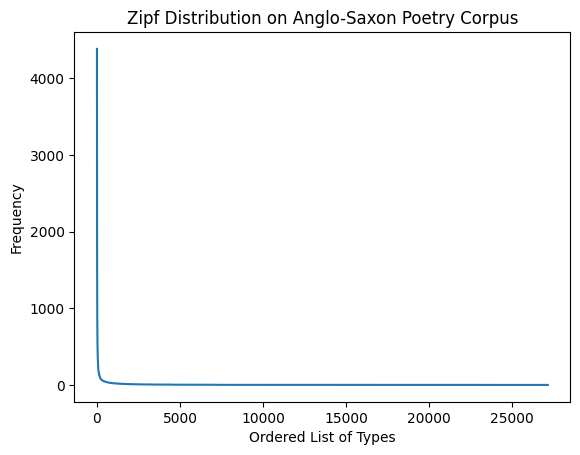

In [ ]:
#Graphing Zipf Distribution on Corpus
ranked_corpus = {i: freq[1] for i, freq in enumerate(sorted(freqlist_corpus.items(), key = lambda x : x[1], reverse = True))}

plt.plot(ranked_corpus.keys(), ranked_corpus.values())
plt.xlabel('Ordered List of Types')
plt.ylabel('Frequency')
plt.title('Zipf Distribution on Anglo-Saxon Poetry Corpus')
plt.show()

###**Exploring the Cleaned (Simplified) Corpus**

I originally went about simplifying the corpus through creating a frequency list of terms. As I carried out the following analysis, I found that the corpus wasn't clean enough, as many of the functional words were coming through in the LDA. Therefore, I came back and applied a different approach. It is for this reason that the following cells are labeled "Most Simplified," as this is the second iteration of cleaning the corpus for analysis.

I found a Wiktionary page which has lists of Old English words per each POS - https://en.wiktionary.org/wiki/Category:Old_English_lemmas. I copied and pasted the categories I deemed necessary to be excluded (listed below) and kept those which I thought to have the largest semantic importance (also listed below). There were also a number of multi-token phrases, in particular in the conjunctions, which had to removed as a full unit. I then went through the frequency list to check for alternative spellings of the excludable words, because this language was written at a time without standardized spelling conventions. I added those alternative spellings to the list and reran the cleaning of the corpus. There were also a few verbs (should, want, must, have, be, become) and a few adverbs (often, sometimes) which I excluded as well for their low semantic contribution and high frequency.

**Excluding:** *conjunctions, determiners, interjections, numerals, particles, prepositions, pronouns.*

**Keeping:** *adjectives, adverbs, nouns, verbs.*

I cannot guarantee that the cleaning is exhaustive, especially since I am no expert in the language, but I deem the work to be suffient given the fact that I'm working with a language with very few computational resources.

###**Metrics:**

* Total Excluded Words: **68,019** tokens.
* Percentage of Corpus Represented by Excluded Words: **38.81%** (more than ten percent higher than the first attempt with only the frequency list!)
* Total Types in Corpus after Cleaning: **26,856**.
* Total Tokens in Corpus after Cleaning: **107,232**.
* Total Characters in Corpus after Cleaning: **783,381**.
* TTR: **25%** (about 10% higher than before!)

###**Following Cells:**

1.   Creates a dictionary of excludable terms, saves as an external a .txt file.
2.   Restores the excludable terms dictionary for working between runtimes.
3.   Writes the entire corpus in a single document for exploration.
4.   Explores the Most Simplified Corpus with a word count, frequency list, and a Zipf distribution graph.



In [ ]:
#Creating a Dictionary for Words to be Excluded

#Defining the lists of terms to be added to the dictionary
excludables = 'ac, ær, ah, and, butan, buton, eala, eallswa, ealswa, for þon þe, forþy, ge, gelice, gif, hu, hwæþer, na, na þæt, næs, ne, nefne, nemne, nu, nymþe, ond, oððe, oþ, oþþæt, oþþe, oþþon, siððan, siþ, siþþan, soþlice, swa, swa swa, swelce, swilce, swylce, syððan, syþþan, ða, þa, þa hwile þe, þænne, þæs, þæs þe, þæt, þætte, þanne, þeah, þenden, þon, þonne, þy, þy læs, þy læs þe,  begen, enig, eower, hwelc, incer, min, nan, nawþer, se, þes, þin, uncer, ure, usær,  afæstla, cwist þu la, eala, eow, erce, God helpe sumes mannes, god wat, gode þanc, hela, henu, huig, hwelc, la, loc, loca, tela, wa la wa,   æhta, an, an and hundteontig, an and twentig, an and twentigoþa, eahta, eahta and twentig, eahta and twentigoþa, eahtateoþa, eahtatiene, eahtoþa, ehta, endlefta, endleofan, endlyfta, feorða, feorþa, feorþa dæl, feower, feower and twentig, feower and twentigoþa, feowerteoþa, feowertiene, feowertig, feowertigoþa, fif, fif and twentig, fif and twentigoþa, fifta, fifteoþa, fiftiene, fiftig, fiftigoþa, hundeahtatig, hundeahtatigoþa, hundendleftig, hundnigontig, hundnigontigoþa, hundred, hundseofontig, hundseofontigoþa, hundteontig, hundteontigoþa, hundtwelftig, nigon, nigon and hundnigontig, nigon and twentig, nigon and twentigoþa, nigon hund, nigonteoþa, nigontiene, nigoþa, oþer, oþer healf, seofon, seofon and twentig, seofon and twentigoþa, seofonteoþa, seofontiene, seofontig, seofoða, seofoþa, seox, siex, siexta, siexteoþa, siextiene, siextig, six, six and twentig, six and twentigoþa, six hund, six þusenda, sixta, sixteoþa, sixtiene, sixtig, sixtigoþa, syx, syxta, ten, teoþa, tien, tu, twa, twa and feowertig, twa and hundnigontig, twa and twentig, twa and twentigoþa, twæde, twelf, twelfta, twentig, twentiga, twentigoþa, twentigþa, þreo, þreo and fiftig, þreo and twentig, þreo and twentigoþa, þreotiene, þreotteoþa, þri, þridda, þridda dæl, þridde, þritig, þritigoþa, þusend,  þe,  abetweonum, abitweonum, æf, æfter, ær, æt, agen, amang, andlang, be, beforan, begeondan, beheonan, behindan, beneoþan, betweonan, betweonum, betweox, betwux, bi, bineoþan, binnan, bufan, butan, buton, eac, for, forð, forþ, fram, gehende, gemang, geond, giend, in, innan, into, mid, middes, mið, neah, neoðan, neoþan, nioðan, nioþan, of, ofer, on, onbutan, ongean, ongegn, ongemang, onlong, onmiddan, oþ, samod, siþ, te, til, to, toeacan, togean, togeanes, toweard, twih, ðerh, ðorh, ðurh, þerh, þorh, þurh, þuruh, under, underneoþan, wiþ, wiþinnan, wiþutan, ymb, ymbe,  æghwæþer, æghwelc, æghwilc, æghwylc, ægþer, alles, awiht, elra, fela, feola, feolo, ferht, ferþ, ge, gehwa, gehwæþer, gehwelc, gehwilc, gehwone, gehwylc, git, he, heo, hi, hie, hiere, hio, hire, hit, huuæt, hwa, hwæt, hwæthwugu, hwæþer, hwelc, hwilc, hwon, hwylc, ic, ih, ilca, iow, iower, man, manig, nænig, nan, nan mann, nan þing, nawiht, nic, nicc, nih, owiht, se, self, seolf, sin, sum, swa, swæþer, swelc, swilc, swylc, sylf, ða, ðæt, þæge, þætte, þeo, þes, þio, þu, þyslic, uncit, user, usser, we, wit, ylca, him, his, me, wæs, þær, þam, is, ðe, ealle, hine, wið, bið, ðu, sceal, us, þone, eall, seo, mine, þine, þære, wæron, wearð, heora, wolde, hæfde, wære, mec, þara, hy, forþon, ðonne, ealra, þas, ðam, ænig, willan, þinum, eal, biþ, eom, meahte, magan, hafaþ, habban, hafað, þis, wille, willan, sculan, sceolde, eallum, beoþ, beoð, beon, minum, wesan, eart, wearþ, weorþan, þæm, ðæs, ms, eft, oft, her, ðær, fore, hyne, et, a, þinre, þines'

#Excludables dictionary using defaultdict
exclude_dict = defaultdict(list)

for phrase in excludables.split(','):
  for i, word in enumerate(phrase.split()):
    if i == 0:
      if phrase.lower().split()[1:] != []:
        exclude_dict[word.lower()].append(' '.join(phrase.lower().split()[1:])) #appends a dictionary with the first word in the phrase and the following words as the value
      else:
        exclude_dict[word.lower()] #appends the single words as keys with empty values

for key, value in exclude_dict.items():
  if value != []:
    exclude_dict[key] = set(value) #makes a set of the values so as to remove duplicates
  else:
    pass

print(dict(list(exclude_dict.items())[:10]))

with open("exclude_dict.txt", 'wb') as fout:
    pickle.dump((exclude_dict), fout) #saves variable for later retrieval

{'ac': [], 'ær': [], 'ah': [], 'and': [], 'butan': [], 'buton': [], 'eala': [], 'eallswa': [], 'ealswa': [], 'for': {'þon þe'}}


In [9]:
#Code to Restore the Excludables Dictionary
with open("exclude_dict.txt", 'rb') as fin:
    exclude_dict = pickle.load(fin)

In [ ]:
#Rerunning the Above Procedure on the Simplified Corpus (DONT RERUN)
r = re.compile(r'[^\w+]')

with open(f'Corpus/Most_Simplified_Corpus.txt', 'w') as fout3:
  for url in corpus_dict.values():
    req = requests.get(url)
    source = req.text
    soup = BeautifulSoup(source)

    excludables = []

    try:
      text = [tag.get_text().strip().lower() for tag in soup.find_all('dd')] #pulls the text from the webpage, strips, and lowercases it

      joined_text = ' '.join(text) #joins together the fragments of texts into a single string

      clean_text = r.sub(' ', joined_text) #cleans the string of punctuation and all non-text elements

      buffed_text = clean_text  + ' XXX XXX XXX' #buffs the end of the string to get around the issue of excluding the final words when using zip()

      for token, token2, token3, token4 in zip(buffed_text.split(), buffed_text.split()[1:], buffed_text.split()[2:], buffed_text.split()[3:]):
        if token in exclude_dict:
          if exclude_dict[token] != []:
            if token2 + ' ' + token3 + ' ' + token4 in exclude_dict[token]: #ensures that all tokens which have a role in excludable ngrams of a length of 4 are added to the list to be excluded
              excludables.append(token)
              excludables.append(token2)
              excludables.append(token3)
              excludables.append(token4)
            elif token2 + ' ' + token3 in exclude_dict[token]: #ensures that all tokens which have a role in excludable ngrams of a length of 3 are added to the list to be excluded
              excludables.append(token)
              excludables.append(token2)
              excludables.append(token3)
            elif token2 in exclude_dict[token]: #ensures that all tokens which have a role in excludable ngrams of a length of 2 are added to the list to be excluded
              excludables.append(token)
              excludables.append(token2)
            else:
              excludables.append(token) #ensures that all tokens which have a role in excludable ngrams, but in this context only appear as a single instance without any following words matching the ngram, are added to the list to be excluded
          else:
            excludables.append(token) #ensures that all tokens which do not have a role in an ngram, but are excludable units nevertheless, are added to the list to be excluded

      excludables = set(excludables) #takes a set of the excludables so as to reduce redundancy

      tokenized_text = [token for token in buffed_text.split() if token not in excludables if token != 'XXX'] #appends a list with the text, as individual tokens, removing the excludables and the end of string buffer

      text_out = ' '.join(tokenized_text) #rejoins the tokens into a single string

      fout3.write(text_out)

    except:
      pass

print('Operation Complete.')

Operation Complete.


     0 107232 783381 Corpus/Most_Simplified_Corpus.txt
------------------------------------------------------------------------------------------------------------------------------------------------------
[('drihten', 523), ('mæg', 346), ('godes', 325), ('eorðan', 313), ('bearn', 250), ('wordum', 247), ('ece', 245), ('word', 219), ('fæder', 213), ('æfre', 211), ('dryhten', 202), ('cyning', 200), ('wuldres', 194), ('mode', 192), ('wide', 185), ('halig', 182), ('georne', 174), ('lifes', 167), ('foldan', 165), ('engla', 163), ('fæste', 163), ('up', 162), ('worulde', 162), ('waldend', 158), ('mod', 156), ('sunu', 155), ('eorþan', 151), ('men', 146), ('manna', 146), ('swiðe', 142), ('rice', 137), ('cwæð', 137), ('weard', 136), ('folc', 136), ('wel', 135), ('heortan', 129), ('soð', 125), ('forðon', 125), ('hyra', 124), ('dæg', 118), ('mon', 118), ('sawle', 117), ('hwilum', 116), ('monna', 114), ('dryhtnes', 114), ('sona', 113), ('mære', 112), ('helle', 111), ('het', 110), ('no', 110), ('ære

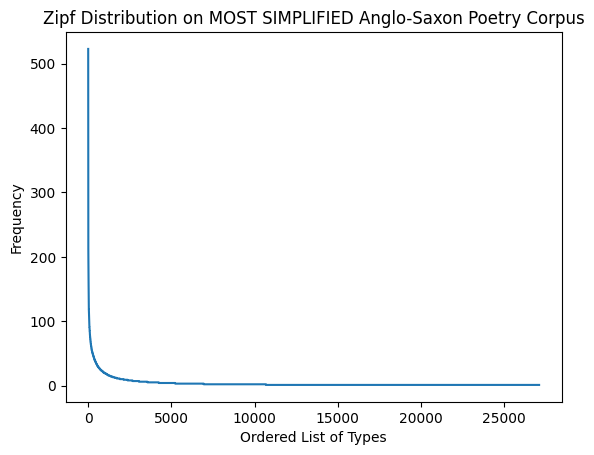

In [ ]:
#Checking the "Most" Simplified Corpus

#Provides the new word count on the simplified corpus
! wc Corpus/Most_Simplified_Corpus.txt

print('-'*150)

#Creates a frequency list from the simplified corpus for comparison
with open('Corpus/Most_Simplified_Corpus.txt', 'r') as corpus_file:
  most_simp_corpus = corpus_file.read()

most_simp_freqlist_corpus = {}

tokens = [token for token in most_simp_corpus.split()]

for token in tokens:
  if token not in most_simp_freqlist_corpus:
    most_simp_freqlist_corpus[token] = 1
  else:
    most_simp_freqlist_corpus[token] += 1

print(sorted(most_simp_freqlist_corpus.items(), key = lambda x : x[1], reverse = True))

print('-'*150)

#Graphs the Zipf Distribution on the simplified corpus
most_simp_ranked_corpus = {i: freq[1] for i, freq in enumerate(sorted(most_simp_freqlist_corpus.items(), key = lambda x : x[1], reverse = True))}

plt.plot(most_simp_ranked_corpus.keys(), most_simp_ranked_corpus.values())
plt.xlabel('Ordered List of Types')
plt.ylabel('Frequency')
plt.title('Zipf Distribution on MOST SIMPLIFIED Anglo-Saxon Poetry Corpus')
plt.show()

##**Scraping**

This stage creates individual documents by scraping the Sacred Texts website for its Anglo-Saxon poetry, so as to prepare for the Document-Term matrix.

In [ ]:
#Producing the Documents for Analysis (DONT RERUN)
r = re.compile(r'[^\w+]')

for title, url in corpus_dict.items():
  req = requests.get(url)
  source = req.text
  soup = BeautifulSoup(source)

  excludables = []

  with open(f'Most Simplified Old English Documents/{title}.txt', 'w') as fout:
    try:
      text = [tag.get_text().strip().lower() for tag in soup.find_all('dd')] #pulls the text from the webpage, strips, and lowercases it

      joined_text = ' '.join(text) #joins together the fragments of texts into a single string

      clean_text = r.sub(' ', joined_text) #cleans the string of punctuation and all non-text elements

      buffed_text = clean_text  + ' XXX XXX XXX'

      for token, token2, token3, token4 in zip(buffed_text.split(), buffed_text.split()[1:], buffed_text.split()[2:], buffed_text.split()[3:]):
        if token in exclude_dict:
          if exclude_dict[token] != []:
            if token2 + ' ' + token3 + ' ' + token4 in exclude_dict[token]: #ensures that all tokens which have a role in excludable ngrams of a length of 4 are added to the list to be excluded
              excludables.append(token)
              excludables.append(token2)
              excludables.append(token3)
              excludables.append(token4)
            elif token2 + ' ' + token3 in exclude_dict[token]: #ensures that all tokens which have a role in excludable ngrams of a length of 3 are added to the list to be excluded
              excludables.append(token)
              excludables.append(token2)
              excludables.append(token3)
            elif token2 in exclude_dict[token]: #ensures that all tokens which have a role in excludable ngrams of a length of 2 are added to the list to be excluded
              excludables.append(token)
              excludables.append(token2)
            else:
              excludables.append(token) #ensures that all tokens which have a role in excludable ngrams, but in this context only appear as a single instance without any following words matching the ngram, are added to the list to be excluded
          else:
            excludables.append(token) #ensures that all tokens which do not have a role in an ngram, but are excludable units nevertheless, are added to the list to be excluded

      excludables = set(excludables) #takes a set of the excludables so as to reduce redundancy

      tokenized_text = [token for token in buffed_text.split() if token not in excludables if token != 'XXX'] #appends a list with the text, as individual tokens, removing the excludables and the end of string buffer

      text_out = ' '.join(tokenized_text) #rejoins the tokens into a single string

      fout.write(text_out)

    except:
      print(title)

print('Operation Complete.')

Operation Complete.


##**Document-Term Matrix**

This stage creates and populates a matrix with documents on the x-axis and tokens on the y-axis.

###**Following Cells:**

1.   Creates and populates the document-term matrix.
2.   Applies different indexing and checks on the matrix to ensure quality and for practice in retriving information from the matrix.
3.   Transforms the matrix into a DataFrame from Pandas for a cleaner visualizzation.



In [ ]:
#Creating and Filling a Doc2Term Matrix

#Populates two lists: docs (entire documents - for matrix), doc_titles (titles of documents - for IDs)
docs = []
doc_titles = []
for fil in glob.glob('/content/gdrive/MyDrive/Computational Linguistics/Final Project/Most Simplified Old English Documents/*.txt'):
  doc_titles.append(fil.split('/')[-1].strip('.txt'))

  with open(fil, 'r') as doc_in:
    docs.append(doc_in.read())

#Populates a dictionary with a frequency list, i.e. vocabulary of document corpus
vocab = {}
for doc in docs:
  for token in doc.split():
    if token not in vocab:
      vocab[token] = 1
    else:
      vocab[token] += 1

#Creates the dimensions of the matrix using the length of the vocabulary and that of the list of documents
mat = lil_matrix((len(docs), len(vocab)))

#Assigns IDs to each token (indexable with 'token_ids['term']') and to each document in the matrix (indexable with 'doc_ids['term']')
token_ids = {token: i for i, token in enumerate(vocab)}
doc_ids = {title: i for i, title in enumerate(doc_titles)}

#Populates the Matrix
for i, doc in enumerate(docs):
  for token in doc.split():
    mat[i, token_ids[token]] +=1

In [ ]:
#Matrix Checks
print('Doc2Term Matrix:')
print(mat.toarray())
print('-' * 50)

print(f'The shape of the matrix is {mat.toarray().shape}.')
print('-' * 50)

print('The column index of "drihten" is %d.'%token_ids['drihten'])
print('-' * 50)

print('The token "drihten" occurs %d times.'%mat[:, 139].sum())
print('-' * 50)

mat[:, 139].toarray() #column for 'drihten' (print only if necessary)

print('The token "drihten" is used in %d articles.'%mat[:, 139].nnz) #(non zeros)
print('-' * 50)

print(f'The row index of "Beowulf" is %d.'%doc_ids['Beowulf'])
print('-' * 50)

print('The row for Beowulf is:', mat[137, :].toarray())

Doc2Term Matrix:
[[ 8. 18.  4. ...  0.  0.  0.]
 [ 4.  3.  0. ...  0.  0.  0.]
 [ 3.  1.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  1.  1.]]
--------------------------------------------------
The shape of the matrix is (347, 26856).
--------------------------------------------------
The column index of "drihten" is 139.
--------------------------------------------------
The token "drihten" occurs 540 times.
--------------------------------------------------
The token "drihten" is used in 135 articles.
--------------------------------------------------
The row index of "Beowulf" is 137.
--------------------------------------------------
The row for Beowulf is: [[ 2. 10.  1. ...  0.  0.  0.]]


In [ ]:
#Visualizing the Matrix with Pandas

#Converts the matrix into an array
mat_arr = mat.toarray()

#Creates lists of document and term IDs
doc_lab = []
for doc in doc_ids.keys():
  doc_lab.append(doc)

token_lab = []
for token in token_ids.keys():
  token_lab.append(token)
token_lab.insert(0, '') #necessary spacer for the labels

#Transforms the above lists into arrays
doc_arr = np.array(doc_lab) #(347,)
tok_arr = np.array(token_lab) #(26857,)

#Reshapes the arrays to add the necessary dimension for concatenation
doc_labels = np.reshape(doc_arr, (347, 1)) #(347, 1)
tok_labels = np.reshape(tok_arr, (1, 26857)) #(1, 26857)

#Adds the labels to the existing matrix
data_docs = np.concatenate([doc_labels, mat_arr], axis = 1)
final_data = np.concatenate([tok_labels, data_docs], axis = 0)

#Visualization
dataframe_corpus = pd.DataFrame(final_data)
dataframe_corpus

,0,1,2,3,4,5,6,7,8,9,...,26847,26848,26849,26850,26851,26852,26853,26854,26855,26856
0,,riht,micel,rodera,weard,wereda,wuldorcining,wordum,herigen,modum,...,awage,weorne,weter,anbre,litel,linsetcorn,miccli,lesse,handwurmes,hupeban
1,"Genesis A, B",8.0,18.0,4.0,20.0,5.0,1.0,46.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Exodus,4.0,3.0,0.0,3.0,1.0,0.0,6.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Christ and Satan,3.0,1.0,2.0,4.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Daniel,1.0,5.0,1.0,22.0,3.0,0.0,7.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,Metrical Charm 8: For a Swarm of Bees,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344,Metrical Charm 9: For Loss of Cattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345,Metrical Charm 10: For Loss of Cattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346,Metrical Charm 11: A Journey Charm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##**Principle Component Analysis (PCA)**

This stage is one method for deducing how the texts fit together topically. The PCA reduces the 26,856 dimensional document-term matrix into its two principle components.

###**Following Cells:**

1.   Transforms the document-term matrix into a Pandas DataFrame and standardizes the values.
2.   Performs PCA on the DataFrame, reducing the 26,856 dimensions into two.
3.   Plots the PCA.
4.   Removes the two outliers and replots the PCA.
5.   Calculates the explained variance through the PCA dimensionality reduction (here 21.66% of variance is explained by PCA).
6.   Investigates which dot groupings belong to which documents.



In [ ]:
#Transforming Matrix into Pandas DataFrame and Standardizing Values
mat_arr = mat.toarray()
mat_df = pd.DataFrame(mat_arr)

sd_df = StandardScaler().fit_transform(mat_df)
sd_df

array([[11.89093866, 13.85860021,  7.88841912, ..., -0.05376033,
        -0.05376033, -0.05376033],
       [ 5.84528926,  2.13521095, -0.17426552, ..., -0.05376033,
        -0.05376033, -0.05376033],
       [ 1.31105221,  3.69832952,  1.84140564, ..., -0.05376033,
        -0.05376033, -0.05376033],
       ...,
       [-0.20036014, -0.2094669 , -0.17426552, ..., -0.05376033,
        -0.05376033, -0.05376033],
       [-0.20036014, -0.2094669 , -0.17426552, ..., -0.05376033,
        -0.05376033, -0.05376033],
       [-0.20036014, -0.2094669 , -0.17426552, ..., 18.60107524,
        18.60107524, 18.60107524]])

In [ ]:
#Performing a PCA on the Corpus Dataframe
pca = PCA(n_components = 2)
pca_mat = pca.fit_transform(sd_df)

#Recreates the document labels (so as to not have to rerun the above dataframe to save RAM)
doc_lab = []
for doc in doc_ids.keys():
  doc_lab.append(doc)
doc_arr = np.array(doc_lab)
doclab_df = pd.DataFrame(doc_arr)

#Creates a dataframe from the PCA data
pca_df = pd.DataFrame(data = pca_mat, columns = ['Principle Component 1', 'Principle Component 2'])

final_df = pd.concat([doclab_df, pca_df], axis = 1)
final_df

,0,Principle Component 1,Principle Component 2
0,"Genesis A, B",282.036164,829.917172
1,Exodus,31.960957,23.340445
2,Daniel,33.770824,40.473295
3,Andreas,132.137535,123.895170
4,Christ and Satan,25.284522,27.735161
...,...,...,...
342,Metrical Charm 8: For a Swarm of Bees,-6.880426,-4.098084
343,Metrical Charm 9: For Loss of Cattle,-6.681179,-3.959659
344,Metrical Charm 10: For Loss of Cattle,-6.695528,-3.824440
345,Metrical Charm 11: A Journey Charm,-6.064503,-3.548274


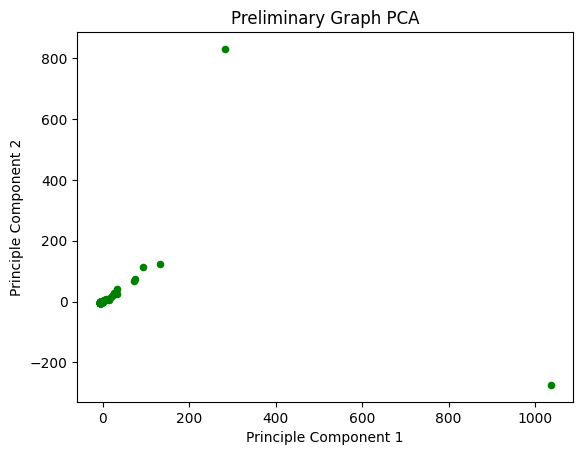

In [ ]:
#Initial Plotting of the PCA
final_df.plot.scatter(x = 'Principle Component 1', y = 'Principle Component 2', title = 'Preliminary Graph PCA', c = 'green')
plt.show()

The outlier on the x-axis is Beowulf.
the outlier on the y-axis is Genesis A, B.
The index for Genesis A, B is 0.
The index for Beowulf is 136.


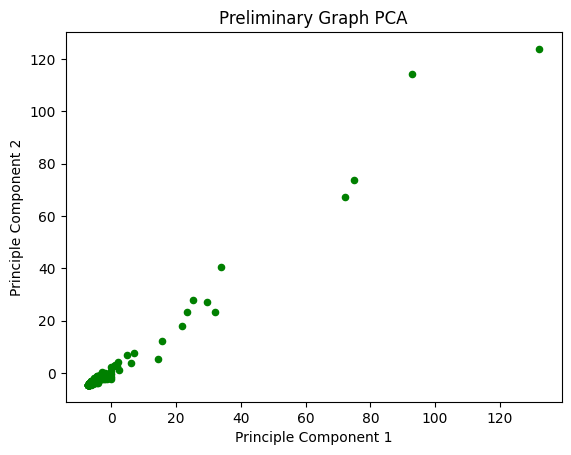

In [ ]:
#Temporarily Removing Outliers and Replotting
for i, x in enumerate(final_df['Principle Component 1']):
  if x > 1000:
    print(f'The outlier on the x-axis is {final_df[0][i]}.')
  else:
    pass

for i, y in enumerate(final_df['Principle Component 2']):
  if y > 800:
    print(f'the outlier on the y-axis is {final_df[0][i]}.')
  else:
    pass

for i, x in enumerate(final_df[0]):
  if x == 'Genesis A, B':
    print(f'The index for Genesis A, B is {i}.')

for i, x in enumerate(final_df[0]):
  if x == 'Beowulf':
    print(f'The index for Beowulf is {i}.')

final_df_nolong = final_df.drop(labels = [0, 136], axis = 0)

final_df_nolong.plot.scatter(x = 'Principle Component 1', y = 'Principle Component 2', title = 'Preliminary Graph PCA', c = 'green')
plt.show()

In [ ]:
#Explained Variance through PCA
print('The present PCA accounts for %g percent of the variance.'%(sum(pca.explained_variance_ratio_) * 100))

###RECOMMENDATIONS ARE FOR 85% OR HIGHER

The present PCA accounts for 21.6605 percent of the variance.


In [ ]:
#Investigating the Groupings of Dots in the PCA
print('The highest grouping of two dots is comprised of:')
for i, x in enumerate(final_df['Principle Component 1']):
  if 200 > x > 90:
    print(final_df[0][i])
  else:
    pass

print('-' * 20)

print('The grouping around 80 (PCA1) is comprised of:')
for i, x in enumerate(final_df['Principle Component 1']):
  if 90 > x > 70:
    print(final_df[0][i])
  else:
    pass

print('-' * 20)

print('The grouping between 10 and 40 (PCA1) is comprised of:')
for i, x in enumerate(final_df['Principle Component 1']):
  if 40 > x > 10:
    print(final_df[0][i])
  else:
    pass

print('-' * 20)

print('The grouping between 4 and 10 (PCA1) is comprised of:')
for i, x in enumerate(final_df['Principle Component 1']):
  if 10 > x > 4:
    print(final_df[0][i])
  else:
    pass

The highest grouping of two dots is comprised of:
Andreas
Christ A, B, C
--------------------
The grouping around 80 (PCA1) is comprised of:
Elene
Guthlac A, B
--------------------
The grouping between 10 and 40 (PCA1) is comprised of:
Exodus
Daniel
Christ and Satan
The Phoeni
Juliana
Judith
The Battle of Maldon
Solomon and Saturn
--------------------
The grouping between 4 and 10 (PCA1) is comprised of:
Maxims I
The Paris Psalter: Psalm 118
The Judgment Day II


##**Latent Dirichlet Analysis (LDA) - Topic Modelling**

This stage applies a Latent Dirichlet Analysis for the purposes of topic modelling on the corpus. The LDA derives topics from texts by grouping those words together which seem to constitute a grouping for as many topics as defined by the user.

This stage experiments with different numbers of topics and passes through the corpus to find the model which best represents the corpus. The first two tests inquire into how many topics best fit the corpus. The result was that three topics had the greatest explanatory power. The final test checks how many passes through the corpus optimizes the Coherence Score of a LDA model characterized by three topics. The final optimized model had a total of three topics with 60 passes through the corpus.

An analysis of the topics and words comes in the following section pyLDAvis.

###**Following Cells:**

1.   Sets up LDA: defines the corpus, the dictionary of terms, and instantiates the Gensim LDA model.
2.   Defines a function to test various topic numbers by calculating Coherence Scores and Perplexity Values.
3.   Creates a series of models for the corpus with topic numbers ranging from two to 50 with steps of two. Plots the results.
4.   Prints the words and topics for the first highest coherence score, i.e. before the first drop off (coherence scores will always increase with more topics, but more topics does not automatically equal better interpretation of the corpus).
5.  Creates a series of models for the corpus with topic numbers ranging from two to ten with steps of one. Plots the results.
6.  Prints the words and topics for the first highest coherence score.
7.  Defines a function to test various pass numbers by calculating Coherence Scores and Perplexity Values while holding topic number constant at three.
8.  Creates a series of models for the corpus with number of passes ranging from ten to 100 with steps of ten. Plots the results.
9.  Prints the words and topics for the first highest coherence score, i.e. gives results of the most optimized model.
10. Saves the results of the top three models to Google Colab for later retrieval, if necessary.
11. Code block to restore the Optimized Model for between runtimes.




In [5]:
#Setting up the LDA
docs = []
docids = {}
for i, fil in enumerate(glob.glob('/content/gdrive/MyDrive/Computational Linguistics/Final Project/Most Simplified Old English Documents/*.txt')):
  with open(fil, 'r') as doc_in:
    docs.append(doc_in.read().split())

  docids[fil.split('/')[-1].strip('.txt')] = i

LDA = gensim.models.ldamodel.LdaModel

dictionary = corpora.Dictionary(docs) #gensim dictionary
corpus = [dictionary.doc2bow(poem) for poem in docs] #term doc freq, corpus

###**Test 1: Number of Topics from 2 - 50**

In [ ]:
#Defining a Function which Tests the LDA Models at Various Topic Numbers by their Coherence Scores and Perplexity Values
def topic_num_eval(dictionary, corpus, docs, start, limit, step):
  mod_list = []
  coh_scores = []
  perplex_values = []

  for num_topics in range(start, limit, step):
    lda_mod = LDA(corpus = corpus, id2word = dictionary, num_topics = num_topics, passes = 15) #creates the LDA model
    mod_list.append(lda_mod)

    perplex_values.append(lda_mod.log_perplexity(corpus, total_docs=348)) #calculates the perplexity value

    coh_mod_lda = CoherenceModel(model = lda_mod, texts = docs, dictionary = dictionary, coherence = 'c_v') #calculates the coherence scores
    coh_scores.append(coh_mod_lda.get_coherence())

  return mod_list, coh_scores, perplex_values

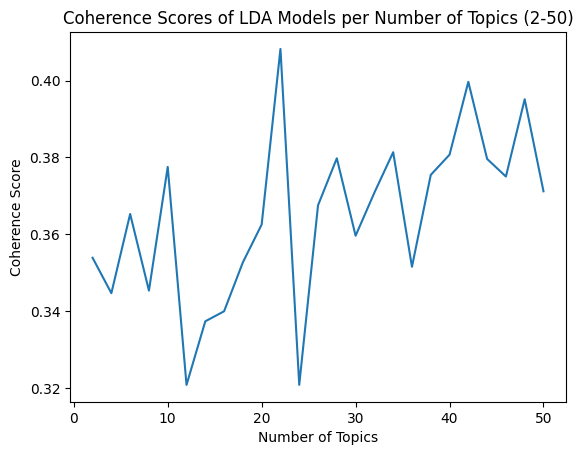

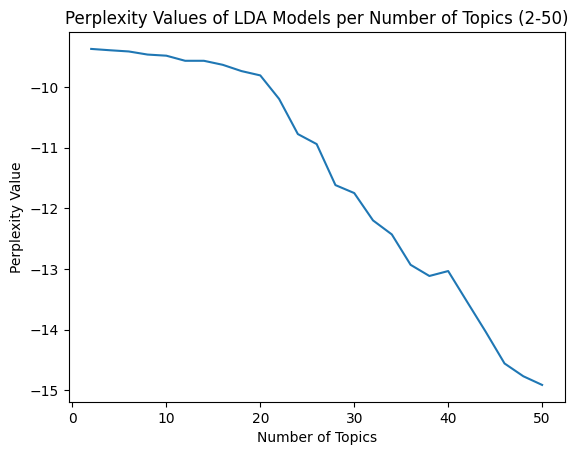

In [ ]:
#Computing and Graphing the Results of LDA Models with Topic Numbers Ranging from 2 to 50 by their Coherence Scores and Perplexity Values
model_list, coherence_scores, perplexity_values = topic_num_eval(dictionary, corpus, docs, 2, 52, 2)

x = range(2, 52, 2)
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores of LDA Models per Number of Topics (2-50)')
plt.show()

x = range(2, 52, 2)
plt.plot(x, perplexity_values)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Value')
plt.title('Perplexity Values of LDA Models per Number of Topics (2-50)')
plt.show()

In [ ]:
#Topic List for the Model with the Highest Coherence Score (before Drop-Off)
model_list[4].print_topics()

[(0,
  '0.004*"mæg" + 0.004*"byþ" + 0.002*"attre" + 0.002*"wiht" + 0.002*"þriwa" + 0.002*"godes" + 0.002*"ðy" + 0.002*"christi" + 0.002*"hiora" + 0.001*"middangeard"'),
 (1,
  '0.004*"cwæð" + 0.004*"text" + 0.003*"mæg" + 0.003*"fæder" + 0.003*"dryhten" + 0.003*"eorðan" + 0.003*"ece" + 0.002*"þec" + 0.002*"fæste" + 0.002*"cyning"'),
 (2,
  '0.003*"mæg" + 0.002*"wordum" + 0.002*"bearn" + 0.002*"no" + 0.002*"hwilum" + 0.002*"mon" + 0.002*"dryhten" + 0.002*"gewat" + 0.002*"cyning" + 0.002*"geata"'),
 (3,
  '0.021*"drihten" + 0.005*"symble" + 0.005*"forðon" + 0.005*"naman" + 0.005*"ece" + 0.004*"georne" + 0.004*"æfre" + 0.004*"eorðan" + 0.003*"manna" + 0.003*"halig"'),
 (4,
  '0.003*"eorþan" + 0.003*"mæg" + 0.002*"scealt" + 0.002*"godes" + 0.002*"sy" + 0.002*"sumum" + 0.002*"wile" + 0.002*"ece" + 0.001*"ful" + 0.001*"foldan"'),
 (5,
  '0.002*"eorðan" + 0.002*"deus" + 0.002*"ðæm" + 0.001*"up" + 0.001*"meaht" + 0.001*"de" + 0.001*"symle" + 0.001*"æfre" + 0.001*"secgan" + 0.001*"tuam"'),
 (6,


###**Test 2: Number of Topics from 2 to 10**

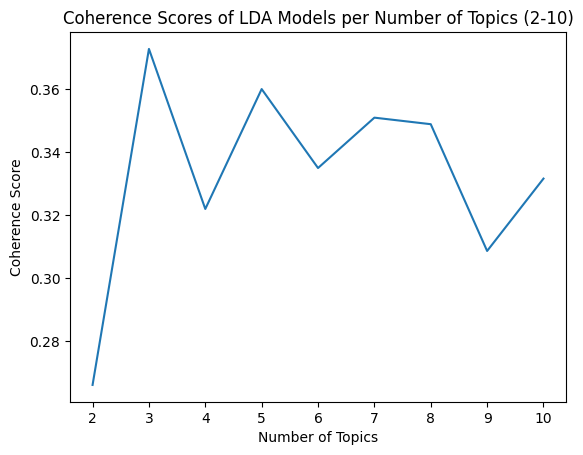

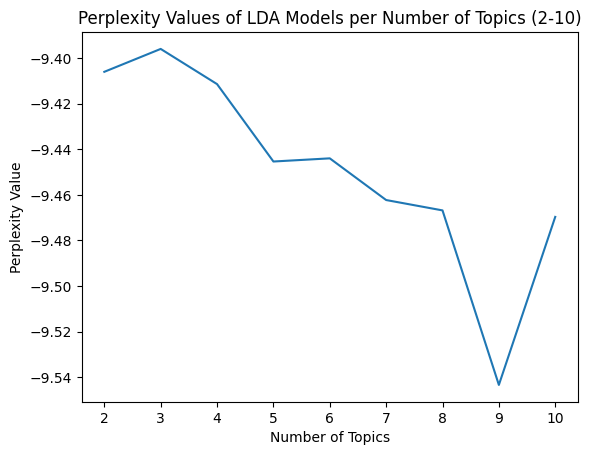

In [ ]:
#Computing and Graphing the Results of LDA Models with Topic Numbers Ranging from 1 to 10 by their Coherence Scores and Perplexity Values
model_list_10, coherence_scores_10, perplexity_values_10 = topic_num_eval(dictionary, corpus, docs, 2, 11, 1)

x = range(2, 11, 1)
plt.plot(x, coherence_scores_10)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores of LDA Models per Number of Topics (2-10)')
plt.show()

x = range(2, 11, 1)
plt.plot(x, perplexity_values_10)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Value')
plt.title('Perplexity Values of LDA Models per Number of Topics (2-10)')
plt.show()

In [ ]:
#Topic List for the Model with the Highest Coherence Score (before Drop-Off)
model_list_10[1].print_topics()

[(0,
  '0.008*"drihten" + 0.003*"eorðan" + 0.003*"ece" + 0.003*"godes" + 0.002*"dryhten" + 0.002*"georne" + 0.002*"æfre" + 0.002*"forðon" + 0.002*"halig" + 0.002*"mode"'),
 (1,
  '0.003*"mæg" + 0.002*"eorþan" + 0.002*"mon" + 0.002*"fæder" + 0.002*"cyning" + 0.002*"bearn" + 0.002*"hwilum" + 0.002*"godes" + 0.001*"foldan" + 0.001*"no"'),
 (2,
  '0.003*"godes" + 0.003*"drihten" + 0.003*"eorðan" + 0.003*"mæg" + 0.002*"wordum" + 0.002*"bearn" + 0.002*"waldend" + 0.002*"up" + 0.002*"wuldres" + 0.002*"sunu"')]

###**Test 3: Number of Passes from 10 to 100**

In [4]:
#Defining a Function which Tests the LDA Models at Various Corpus Passes by their Coherence Scores and Perplexity Values (Number of Topics Held Constant)
def pass_num_eval(dictionary, corpus, docs, start, limit, step):
  mod_list = []
  coh_scores = []
  perplex_values = []

  for num_passes in range(start, limit, step):
    lda_mod = LDA(corpus = corpus, id2word = dictionary, num_topics = 3, passes = num_passes) #creates the LDA model
    mod_list.append(lda_mod)

    perplex_values.append(lda_mod.log_perplexity(corpus, total_docs=348)) #calculates the perplexity value

    coh_mod_lda = CoherenceModel(model = lda_mod, texts = docs, dictionary = dictionary, coherence = 'c_v') #calculates the coherence score
    coh_scores.append(coh_mod_lda.get_coherence())

  return mod_list, coh_scores, perplex_values

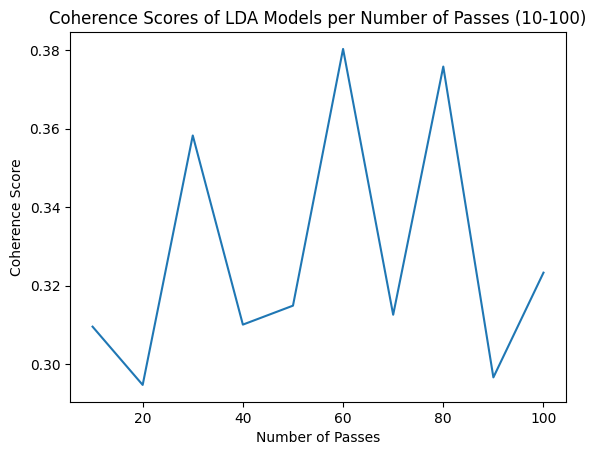

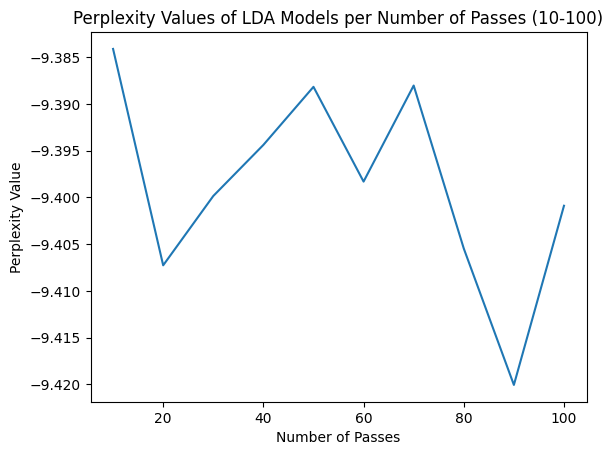

In [6]:
#Computing and Graphing the Results of LDA Models with Corpus Passes Ranging from 10 to 100 by their Coherence Scores and Perplexity Values
model_list_pass, coherence_scores_pass, perplexity_values_pass = pass_num_eval(dictionary, corpus, docs, 10, 110, 10)

x = range(10, 110, 10)
plt.plot(x, coherence_scores_pass)
plt.xlabel('Number of Passes')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores of LDA Models per Number of Passes (10-100)')
plt.show()

x = range(10, 110, 10)
plt.plot(x, perplexity_values_pass)
plt.xlabel('Number of Passes')
plt.ylabel('Perplexity Value')
plt.title('Perplexity Values of LDA Models per Number of Passes (10-100)')
plt.show()

In [10]:
model_list_pass[5].print_topics()

[(0,
  '0.003*"text" + 0.002*"mæg" + 0.002*"hyre" + 0.001*"hwilum" + 0.001*"eorþan" + 0.001*"hyra" + 0.001*"domine" + 0.001*"fæste" + 0.001*"het" + 0.001*"swiþe"'),
 (1,
  '0.002*"mæg" + 0.002*"mon" + 0.002*"bearn" + 0.001*"no" + 0.001*"hwilum" + 0.001*"wide" + 0.001*"sunu" + 0.001*"gumena" + 0.001*"cyning" + 0.001*"manna"'),
 (2,
  '0.006*"drihten" + 0.004*"godes" + 0.003*"eorðan" + 0.003*"mæg" + 0.003*"ece" + 0.002*"wordum" + 0.002*"word" + 0.002*"æfre" + 0.002*"bearn" + 0.002*"wuldres"')]

In [11]:
#Saving Optimized LDA Model
optimal_mod = model_list_pass[5]
suboptimal_mod = model_list_pass[7]
subsuboptimal_mod = model_list_pass[2]


with open("optimal_mod.txt", 'wb') as fout:
    pickle.dump((optimal_mod), fout)

with open("suboptimal_mod.txt", 'wb') as fout:
    pickle.dump((suboptimal_mod), fout)

with open("subsuboptimal_mod.txt", 'wb') as fout:
    pickle.dump((subsuboptimal_mod), fout)

In [ ]:
#For Reloading the Optimized LDA Model
with open("optimal_mod.txt", 'rb') as fin:
    optimal_mod = pickle.load(fin)

##**pyLDAvis**

This section plots the pyLDAvis interactive graph for the LDA model with the highest coherence score for three topics (here with 60 passes through the corpus).

It seems that topic #1 represents the religious texts, as the most relevant words include:

*   **drihten** - lord, The Lord
*   **godes** - GEN.SG good; god's, God's
*   **eorðan** - (mult. declensions) ground, dirt, Earth
*   **mæg** - relative (family); power, might; can
*   **ece** - ache; eternal, durable

Topic #2 is less immediately obvious as to what topics it covers from the following most relevant words:

*   **mæg** - relative (family); power, might; can
*   **mon** - man
*   **bearn** - baby, child; 1/3SG Pret. to run into/by, to happen/occur; place to store barley
*   **no** - no, not, never
*   **hwilum** - sometimes; once

That being said, it is the only topic in which the name Beowulf appears, which leads me to believe that this topic is conditioned primarily by *Beowulf*, especially due to the poem's length. If that is the case, other relevant words (in my opinion) which occur in this grouping would be:

*  **gumena** - GEN.PL man, hero
*  **cyning** - king
*  **sunu** - son, male child
*  **helm** - helmet; protection, defense
*  **leodum** - DAT man, chief, leader; prince (poetic)

Topic #3 is the smallest of the three topics, accounting for only 7% of tokens. The most prevalent word in this grouping was 'text,' which was a scraping mistake of a single poem, *Juliana*. *Juliana* had a lengthy 'Notes' section which no other poem had, in which a hyperlink on the word 'text' brings the reader back to the specific part of the text where that note refers - hence why the word 'text,' a Latin derived word, appears so frequently in the corpus. Since it is a solitary mistake, I chose to overlook it and take the following five most relevant words for this grouping:

*  **mæg** - relative (family); power, might; can
*  **hyre** - (mult. declensions) hire, wages; interest, usury
*  **hwilum** - sometimes; once
*  **eorþan** - (mult. declensions) ground, dirt, Earth
*  **hyra** - (mult. declensions) hire, wages; interest, usury

I predict that the first two groupings/topics were conditioned primarily by *Genesis A, B* and *Beowulf*, as they were the two major outliers in the PCA analysis and the two longest texts in the corpus. The first topic, the religious one, is bigger on the account that there were quite a few religious texts in the corpus other than *Genesis A, B*, while the second topic may have been conditioned primarily by Beowulf, and is therefore a bit smaller. The third topic may be then the rest of the texts in the corpus, which grouped together in a cloud in the PCA analysis, each of which of modest length and therefore of modest lexical contribution to the LDA. It is interesting, however, that two variations of the concept 'hire/wages/interst' came up frequently in this grouping.

###**Following Cells:**

1.   Installs and imports the necessary packages for the pyLDAvis interactive graph.
2.   Plots the pyLDAvis for the Optimized Model.
3.   Plots the pyLDAvis for the second best model.
4.   Plots the pyLDAvis for the third best model.

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
! pip install pandas==1.5.3

In [13]:
#Visualizzing the Results of the Optimized LDA Model
vis = pyLDAvis.gensim_models.prepare(optimal_mod, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.103188  0.031447       1        1  71.305308
1     -0.016099 -0.084288       2        1  21.656424
0     -0.087089  0.052842       3        1   7.038268, topic_info=         Term        Freq       Total Category  logprob  loglift
2632      mæg  287.000000  287.000000  Default  30.0000  30.0000
2157   hwilum   88.000000   88.000000  Default  29.0000  29.0000
13900    text   24.000000   24.000000  Default  28.0000  28.0000
2198     hyre   56.000000   56.000000  Default  27.0000  27.0000
858    eorþan  122.000000  122.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
2519      men    5.430341  120.885487   Topic3  -7.2402  -0.4490
3796     wide    5.583135  154.331782   Topic3  -7.2124  -0.6655
212     bearn    5.466052  211.952772   Topic3  -7.2336  -1.0040
3941   wordum    5.301791  211.835733   Topic3  -7.2641  -1.0340
8436     sume    4.664483   48.231249   Topic3  -7.3922   0.3178

[247 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
15         1  0.973707   abraham
15         2  0.018372   abraham
16         1  0.996540  abrahame
19918      1  0.997605     ahwær
5268       1  0.997075    alysde
...      ...       ...       ...
4252       2  0.519821        ðy
23961      3  0.973053   þegenas
4324       1  0.945427     þinne
4324       2  0.023636     þinne
4324       3  0.023636     þinne

[384 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

###**pyLDAvis for Suboptimal Mods**

The following section plots interactive graphs for the two other LDA models whose coherence scores came in second and third to the Optimal Model.

In [14]:
vis = pyLDAvis.gensim_models.prepare(suboptimal_mod, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.077720  0.039037       1        1  50.636901
0      0.003756 -0.072914       2        1  26.395732
2     -0.081476  0.033877       3        1  22.967367, topic_info=           Term        Freq       Total Category  logprob  loglift
660     drihten  458.000000  458.000000  Default  30.0000  30.0000
13900      text   41.000000   41.000000  Default  29.0000  29.0000
5564       gæst   59.000000   59.000000  Default  28.0000  28.0000
6341   dryhtnes   88.000000   88.000000  Default  27.0000  27.0000
6337    dryhten  159.000000  159.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
831       engla   31.640601  130.037745   Topic3  -6.6604   0.0577
2577       mode   32.562740  157.576063   Topic3  -6.6317  -0.1056
212       bearn   33.767712  206.971022   Topic3  -6.5954  -0.3420
848      eorðan   34.587917  260.674138   Topic3  -6.5714  -0.5487
1864      halig   29.670520  149.005499   Topic3  -6.7247  -0.1427

[266 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
15         1  0.939640      abraham
15         2  0.057529      abraham
6004       1  0.117972         agef
6004       2  0.825807         agef
19918      1  0.973352        ahwær
...      ...       ...          ...
11638      2  0.193306         þonc
11638      3  0.837659         þonc
5250       2  0.983395  þusendmælum
15806      2  0.983401            ᚩ
15809      2  0.983408            ᚻ

[407 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [15]:
vis = pyLDAvis.gensim_models.prepare(subsuboptimal_mod, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.078517  0.043737       1        1  53.841334
1     -0.023803 -0.062710       2        1  25.612321
2      0.102320  0.018974       3        1  20.546345, topic_info=         Term        Freq       Total Category  logprob  loglift
660   drihten  408.000000  408.000000  Default  30.0000  30.0000
3473   symble   78.000000   78.000000  Default  29.0000  29.0000
1107   forðon   95.000000   95.000000  Default  28.0000  28.0000
2672    naman   81.000000   81.000000  Default  27.0000  27.0000
4164     æfre  165.000000  165.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
2003  heortan   34.067427  103.153883   Topic3  -6.4751   0.4746
2632      mæg   40.763220  284.099942   Topic3  -6.2957  -0.3591
3950  worulde   32.213647  133.805933   Topic3  -6.5311   0.1585
1767    godes   33.024906  263.336157   Topic3  -6.5062  -0.4937
1004     folc   31.069223  109.716610   Topic3  -6.5673   0.3208

[274 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
15         1  1.000033  abraham
19918      2  0.073814    ahwær
19918      3  0.922675    ahwær
85         1  0.848956    aldor
85         2  0.110733    aldor
...      ...       ...      ...
7907       1  0.231497   þreate
7907       2  0.771657   þreate
13268      1  0.074579    þriwa
13268      2  0.745787    þriwa
13268      3  0.149157    þriwa

[462 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

#**~ PART 2 - NGRAMS ~**

This part of the project repeats the work of the previous part, but takes into account also common Anglo-Saxon Ngrams. The part follows a streamlined analysis.

##**Scraping**

Scraping followed the same process as before, only that this time an additional dictionary was defined to house the Ngrams of Old English. These Ngrams were derived from the same website which was used to define which tokens to exclude (https://en.wiktionary.org/wiki/Category:Old_English_lemmas), as there was also a section on 'Multiword Terms' and 'Phrases.' This dictionary was applied to each poem, attaching Ngram units of upwards of six tokens together with an underscore.

In [7]:
#Creating a Dictionary for Ngrams

#Defining the lists of terms to be added to the dictionary
ngrams = 'a to feore, æfterra geola, æfterra liþa, ælf sciene, ænge ðinga, ær oþþe lator, ærest ðinga, ærra geola, ærra liþa, æt fruman, æt ham, æt nextan, æt þearfe man sceal freonda cunnian, agen nama, an and hundteontig, an and twentig, an and twentigoþa, and swa forþ, Angelcynnes land, bebeodendlic gemet, beo sibb betwux eow, bi hwon, boca streon, Burgenda land, Cantwara burg, carles wæn, cattes minte, cealfra hus, Cristes mæsse, Cristes mæsseæfen, Cristes mæssedæg, Cristes mæsseniht, Cristes mæsseuhta, cwist þu la, cyninges wyrt, dæges eage, deaþes ege, Defena scir, Dena lagu, don of, don on, eagena gesiht, eahta and twentig, eahta and twentigoþa, eala gif, eald fæder, eald modor, ealdra cwena spell, ealle hwile, ealle niht, ealne dæg, ealne weg, ealra halgena mæsseæfen, ealra mæst, ealra swiþost, Egypta land, Engla land, Eota land, feorþa dæl, feower and twentig, feower and twentigoþa, fif and twentig, fif and twentigoþa, Finna land, fira bearn, for hwon, for þon þe, forþ rihte, foxes glofa, friend wyrcan, Frisena land, full mona, ga onweg, geaces sure, geares dæg, gecyrr ham, gehu elles, geliefst þu on God, gemænelic nama, geþyld byþ middes eades, geweorþe leoht, God ana wat, God helpe sumes mannes, god wat, God wat, gode þanc, Gode þanc, Godes ðances, greate wyrt, grundleas pytt, hæleþa bearn, Halig Gast, hamora laf, har steorra, heafod cweccan, healf tid, heonan forþ, hierdelicu giemen, hlid geat, hu eald eart þu, hu færest þu, hu færst þu, hu geares, hu gerades, hu mæg beon butan, hu mæg þæt beon, hu meta, hu micel sceal ic þe, hu nyta, Hu ðonne, hunda hus, huru ðinga, hwænne bið he acenned, hwænne mot ic hine geseon, hwær eart þu, hwæt eart þu, hwæt gif, hwanon eart þu, ic beo mid eow, ic lufige þe, ic nat, ielda bearn, Ira land, Iringes weg, Langa Frigedæg, Lundene brycg, lytel finger, mæces ecg, manna bearn, mannes getawa, mennesc gecynd, mennisc mann, Mercna land, miceles to, mid Godes giefe, middes wintres dæg, middes wintres mæssedæg, middes wintres mæsseniht, modes hiwung, monan asprungennes, na to þæs hwon, na þæt, næfre eft, næfre ma, nan mann, nan þing, nane ðinga, nigon and hundnigontig, nigon and twentig, nigon and twentigoþa, nigon hund, nu rihte, ofer niht, on ecnesse, on ende, on fotum, on frecennesse, on gemynd, on godes naman, on Godes naman, on hand gan, on idel, on mod berinnan, on þissum dagum, on wæl feallan, on weg, on weorce, onweg gan, onweg weorpan, oðres healfes, oþ deaþ ondrædan, oþer healf, oþer twega, papol stan, Peohta land, rode tacen, rode tacn, Romana rice, Rome burg, Scotta land, seofon and twentig, seofon and twentigoþa, sibb and stilnes, Sigelhearwena land, six and twentig, six and twentigoþa, six hund, six þusenda, spricst þu Englisc, sunnan asprungennes, sunnan scima, swa swa, sweordes ecg, sy hælo, to æfenes, to bedde gan, to dæge, to geflites, to gifes, to hwon to medes, to morgne, to niht, to nones, to setle gan, to uhtes, twa and feowertig, twa and hundnigontig, twa and twentig, twa and twentigoþa, þa hwile þe, þær ys an to lafe, þæs þe, þæt is, þreo and fiftig, þreo and twentig, þreo and twentigoþa, þridda dæl, þy læs, þy læs þe, þynne meolc, þynnu meolc, þyrnen beag, wa la wa, West Seaxe, wide and side, wilde fyr, Wineda land, wintres dæg, witena gemot, wuna mid me, Χp̃es mæssa, ꝥ is, and swa forþ, beo sibb betwux eow, eala gif, gecyrr ham, geliefst þu on God, geweorþe leoht, God ana wat, God wat, hu eald eart þu, hu færest þu, hu færst þu, hu mæg beon butan, hu mæg þæt beon, hu micel sceal ic þe, Hu ðonne, hwænne bið he acenned, hwænne mot ic hine geseon, hwær eart þu, hwæt eart þu, hwanon eart þu, ic beo mid eow, ic lufige þe, ic nat, mid Godes giefe, na to þæs hwon, spricst þu Englisc, sy hælo, þær ys an to lafe, wuna mid me'

#Ngrams dictionary using defaultdict
ngram_dict = defaultdict(list)

for phrase in ngrams.split(','):
  for i, word in enumerate(phrase.split()):
    if i == 0:
      ngram_dict[word.lower()].append(' '.join(phrase.lower().split()[1:])) #appends a dictionary with the first word in the ngram as the key and the following phrase as the value

for key, value in ngram_dict.items():
  ngram_dict[key] = set(value) #makes a set of the values so as to remove duplicates

print(dict(list(ngram_dict.items())[:10]))

with open("ngram_dict.txt", 'wb') as fout:
    pickle.dump((ngram_dict), fout) #saves variable for later retrieval

{'a': {'to feore'}, 'æfterra': {'geola', 'liþa'}, 'ælf': {'sciene'}, 'ænge': {'ðinga'}, 'ær': {'oþþe lator'}, 'ærest': {'ðinga'}, 'ærra': {'geola', 'liþa'}, 'æt': {'þearfe man sceal freonda cunnian', 'fruman', 'nextan', 'ham'}, 'agen': {'nama'}, 'an': {'and hundteontig', 'and twentigoþa', 'and twentig'}}


In [8]:
#Code to Restore the Ngrams Dictionary
with open("ngram_dict.txt", 'rb') as fin:
    ngram_dict = pickle.load(fin)

In [ ]:
#Code to Restore the Excludables Dictionary
with open("exclude_dict.txt", 'rb') as fin:
    exclude_dict = pickle.load(fin)

In [10]:
#The Same Code as Before which Creates Single Documents for Each Poem - This Time Connecting Ngrams Together
r = re.compile(r'[^\w+]')

for title, url in corpus_dict.items():
  req = requests.get(url)
  source = req.text
  soup = BeautifulSoup(source)

  excludables = []
  out = []

  with open(f'Ngrams Old English Documents/{title}.txt', 'w') as fout:
    try:
      text = [tag.get_text().strip().lower() for tag in soup.find_all('dd')] #pulls the text from the webpage, strips, and lowercases it

      joined_text = ' '.join(text) #joins together the fragments of texts into a single string

      clean_text = r.sub(' ', joined_text) #cleans the string of punctuation and all non-text elements

      buffed_text = clean_text  + ' XXX XXX XXX XXX XXX' #buffs the end of the string to get around the issue of excluding the final words when using zip()

      for token, token2, token3, token4, token5, token6 in zip(buffed_text.split(), buffed_text.split()[1:], buffed_text.split()[2:], buffed_text.split()[3:], buffed_text.split()[4:], buffed_text.split()[5:]):
        if token in ngram_dict:
          if token2 + ' ' + token3 + ' ' + token4 + ' ' + token5 + ' ' + token6 in ngram_dict[token]:
            out.append(token + '_' + token2 + '_' + token3 + '_' + token4 + '_' + token5 + '_' + token6) #connects ngrams of a length of 6 together with underscores
          elif token2 + ' ' + token3 + ' ' + token4 + ' ' + token5 in ngram_dict[token]:
            out.append(token + '_' + token2 + '_' + token3 + '_' + token4 + '_' + token5) #connects ngrams of a length of 5 together with underscores
          elif token2 + ' ' + token3 + ' ' + token4 in ngram_dict[token]:
            out.append(token + '_' + token2 + '_' + token3 + '_' + token4) #connects ngrams of a length of 4 together with underscores
          elif token2 + ' ' + token3 in ngram_dict[token]:
            out.append(token + '_' + token2 + '_' + token3) #connects ngrams of a length of 3 together with underscores
          elif token2 in ngram_dict[token]:
            out.append(token + '_' + token2) #connects ngrams of a length of 2 together with underscores
          else:
            pass
        else:
          out.append(token) #appends all remaining tokens, i.e. non ngrams, to the 'out' list for further processing

      for x in range(0, 3):
        out.append('XXX') #rebuffs the text for the following removal of excludable tokens

      for token, token2, token3, token4 in zip(out, out[1:], out[2:], out[3:]):
        if token in exclude_dict:
          if exclude_dict[token] != []:
            if token2 + ' ' + token3 + ' ' + token4 in exclude_dict[token]: #ensures that all tokens which have a role in excludable ngrams of a length of 4 are added to the list to be excluded
              excludables.append(token)
              excludables.append(token2)
              excludables.append(token3)
              excludables.append(token4)
            elif token2 + ' ' + token3 in exclude_dict[token]: #ensures that all tokens which have a role in excludable ngrams of a length of 3 are added to the list to be excluded
              excludables.append(token)
              excludables.append(token2)
              excludables.append(token3)
            elif token2 in exclude_dict[token]: #ensures that all tokens which have a role in excludable ngrams of a length of 2 are added to the list to be excluded
              excludables.append(token)
              excludables.append(token2)
            else:
              excludables.append(token) #ensures that all tokens which have a role in excludable ngrams, but in this context only appear as a single instance without any following words matching the ngram, are added to the list to be excluded
          else:
            excludables.append(token)

      excludables = set(excludables) #takes a set of the excludables so as to reduce redundancy

      tokenized_text = [token for token in out if token not in excludables if token != 'XXX'] #appends a list with the text, as individual tokens, removing the excludables and the end of string buffer

      text_out = ' '.join(tokenized_text) #rejoins the tokens into a single string

      fout.write(text_out)

    except:
      pass

##**Document-Term Matrix**

In [11]:
#Creating and Filling a Doc2Term Matrix

#Populates two lists: docs (entire documents - for matrix), doc_titles (titles of documents - for IDs)
docs = []
doc_titles = []
for fil in glob.glob('/content/gdrive/MyDrive/Computational Linguistics/Final Project/Ngrams Old English Documents/*.txt'):
  doc_titles.append(fil.split('/')[-1].strip('.txt'))

  with open(fil, 'r') as doc_in:
    docs.append(doc_in.read())

#Populates a dictionary with a frequency list, i.e. vocabulary of document corpus
vocab = {}
for doc in docs:
  for token in doc.split():
    if token not in vocab:
      vocab[token] = 1
    else:
      vocab[token] += 1

#Creates the dimensions of the matrix using the length of the vocabulary and that of the list of documents
mat_ngram = lil_matrix((len(docs), len(vocab)))

#Assigns IDs to each token (indexable with 'token_ids['term']') and to each document in the matrix (indexable with 'doc_ids['term']')
token_ids = {token: i for i, token in enumerate(vocab)}
doc_ids = {title: i for i, title in enumerate(doc_titles)}

#Populates the Matrix
for i, doc in enumerate(docs):
  for token in doc.split():
    mat_ngram[i, token_ids[token]] +=1

##**PCA**

In [18]:
#Transforming Matrix into Pandas Dataframe and Standardizing Results
mat_arr = mat_ngram.toarray()
mat_df = pd.DataFrame(mat_arr)

sd_df = StandardScaler().fit_transform(mat_df)
sd_df

array([[11.89093866, 13.85860021,  7.88841912, ..., -0.05376033,
        -0.05376033, -0.05376033],
       [ 5.84528926,  2.13521095, -0.17426552, ..., -0.05376033,
        -0.05376033, -0.05376033],
       [ 1.31105221,  3.69832952,  1.84140564, ..., -0.05376033,
        -0.05376033, -0.05376033],
       ...,
       [-0.20036014, -0.2094669 , -0.17426552, ..., -0.05376033,
        -0.05376033, -0.05376033],
       [-0.20036014, -0.2094669 , -0.17426552, ..., -0.05376033,
        -0.05376033, -0.05376033],
       [-0.20036014, -0.2094669 , -0.17426552, ..., 18.60107524,
        18.60107524, 18.60107524]])

In [25]:
#Performing a PCA on the Corpus Dataframe
pca = PCA(n_components = 2)
pca_mat = pca.fit_transform(sd_df)

#Recreates the document labels (so as to not have to rerun the above dataframe to save RAM)
doc_lab = []
for doc in doc_ids.keys():
  doc_lab.append(doc)
doc_arr = np.array(doc_lab)
doclab_df = pd.DataFrame(doc_arr)

#Creates a dataframe from the PCA data
pca_df = pd.DataFrame(data = pca_mat, columns = ['Principle Component 1', 'Principle Component 2'])

final_df_ngram = pd.concat([doclab_df, pca_df], axis = 1)
final_df_ngram

,0,Principle Component 1,Principle Component 2
0,"Genesis A, B",280.088184,829.972737
1,Exodus,31.737280,23.331999
2,Daniel,33.511225,40.307913
3,Christ and Satan,24.967844,27.450931
4,Andreas,131.183280,123.574137
...,...,...,...
342,Metrical Charm 8: For a Swarm of Bees,-6.919933,-4.153272
343,Metrical Charm 9: For Loss of Cattle,-6.656287,-3.970197
344,Metrical Charm 10: For Loss of Cattle,-6.678578,-3.854080
345,Metrical Charm 11: A Journey Charm,-6.064376,-3.599923


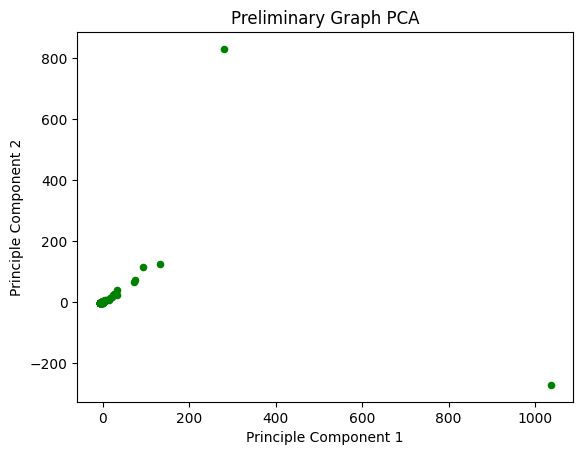

In [26]:
#Plotting of the PCA
final_df_ngram.plot.scatter(x = 'Principle Component 1', y = 'Principle Component 2', title = 'Preliminary Graph PCA', c = 'green')
plt.show()

The outlier on the x-axis is Beowulf.
the outlier on the y-axis is Genesis A, B.
The index for Genesis A, B is 0.
The index for Beowulf is 136.


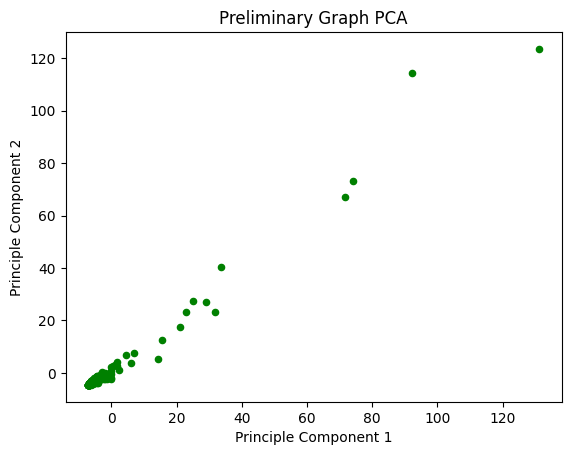

In [30]:
#Temporarily Removing Outliers and Replotting
for i, x in enumerate(final_df_ngram['Principle Component 1']):
  if x > 1000:
    print(f'The outlier on the x-axis is {final_df_ngram[0][i]}.')
  else:
    pass

for i, y in enumerate(final_df_ngram['Principle Component 2']):
  if y > 800:
    print(f'the outlier on the y-axis is {final_df_ngram[0][i]}.')
  else:
    pass

for i, x in enumerate(final_df_ngram[0]):
  if x == 'Genesis A, B':
    print(f'The index for Genesis A, B is {i}.')

for i, x in enumerate(final_df_ngram[0]):
  if x == 'Beowulf':
    print(f'The index for Beowulf is {i}.')

final_df_nolong = final_df_ngram.drop(labels = [0, 136], axis = 0)

final_df_nolong.plot.scatter(x = 'Principle Component 1', y = 'Principle Component 2', title = 'Preliminary Graph PCA', c = 'green')
plt.show()

In [28]:
#Explained Variance through PCA
print('The present PCA accounts for %g percent of the variance.'%(sum(pca.explained_variance_ratio_) * 100))

###RECOMMENDATIONS ARE FOR 85% OR HIGHER

The present PCA accounts for 21.6359 percent of the variance.


In [29]:
#Investigating the Groupings of Dots in the PCA
print('The highest grouping of two dots is comprised of:')
for i, x in enumerate(final_df_ngram['Principle Component 1']):
  if 200 > x > 90:
    print(final_df_ngram[0][i])
  else:
    pass

print('-' * 20)

print('The grouping around 80 (PCA1) is comprised of:')
for i, x in enumerate(final_df_ngram['Principle Component 1']):
  if 90 > x > 70:
    print(final_df_ngram[0][i])
  else:
    pass

print('-' * 20)

print('The grouping between 10 and 40 (PCA1) is comprised of:')
for i, x in enumerate(final_df_ngram['Principle Component 1']):
  if 40 > x > 10:
    print(final_df_ngram[0][i])
  else:
    pass

print('-' * 20)

print('The grouping between 4 and 10 (PCA1) is comprised of:')
for i, x in enumerate(final_df_ngram['Principle Component 1']):
  if 10 > x > 4:
    print(final_df_ngram[0][i])
  else:
    pass

The highest grouping of two dots is comprised of:
Andreas
Christ A, B, C
--------------------
The grouping around 80 (PCA1) is comprised of:
Elene
Guthlac A, B
--------------------
The grouping between 10 and 40 (PCA1) is comprised of:
Exodus
Daniel
Christ and Satan
The Phoeni
Juliana
Judith
The Battle of Maldon
Solomon and Saturn
--------------------
The grouping between 4 and 10 (PCA1) is comprised of:
Maxims I
The Paris Psalter: Psalm 118
The Judgment Day II


##**LDA**

In [31]:
#Setting up the LDA
docs = []
docids = {}
for i, fil in enumerate(glob.glob('/content/gdrive/MyDrive/Computational Linguistics/Final Project/Ngrams Old English Documents/*.txt')):
  with open(fil, 'r') as doc_in:
    docs.append(doc_in.read().split())

  docids[fil.split('/')[-1].strip('.txt')] = i

LDA = gensim.models.ldamodel.LdaModel

dictionary = corpora.Dictionary(docs) #gensim dictionary
corpus = [dictionary.doc2bow(poem) for poem in docs] #term doc freq, corpus

In [32]:
#Defining a Function which Tests the LDA Models at Various Corpus Passes by their Coherence Scores and Perplexity Values (Number of Topics Held Constant)
def pass_num_eval(dictionary, corpus, docs, start, limit, step):
  mod_list = []
  coh_scores = []
  perplex_values = []

  for num_passes in range(start, limit, step):
    lda_mod = LDA(corpus = corpus, id2word = dictionary, num_topics = 3, passes = num_passes) #creates the LDA model
    mod_list.append(lda_mod)

    perplex_values.append(lda_mod.log_perplexity(corpus, total_docs=348)) #calculates the perplexity value

    coh_mod_lda = CoherenceModel(model = lda_mod, texts = docs, dictionary = dictionary, coherence = 'c_v') #calculates the coherence score
    coh_scores.append(coh_mod_lda.get_coherence())

  return mod_list, coh_scores, perplex_values

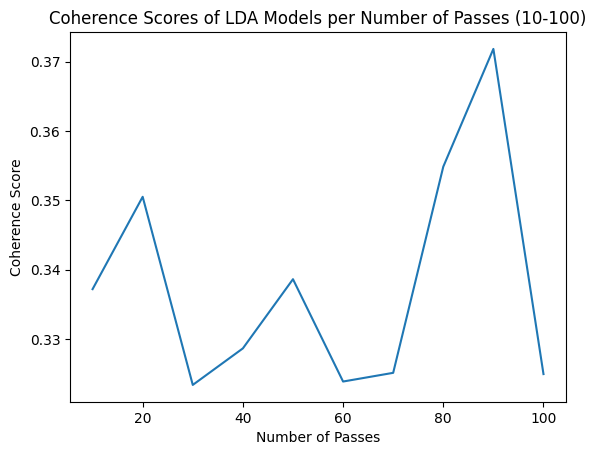

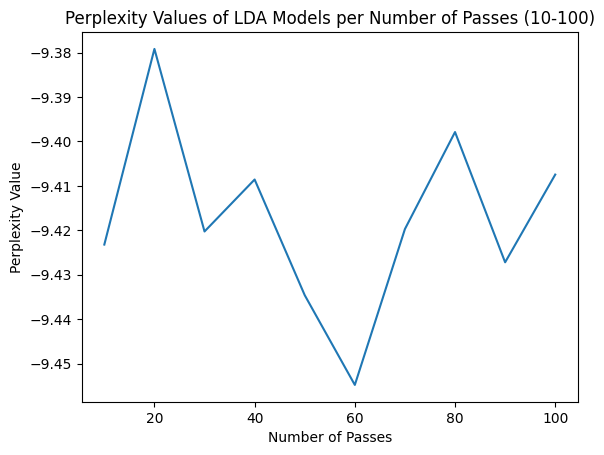

In [33]:
#Computing and Graphing the Results of LDA Models with Corpus Passes Ranging from 10 to 100 by their Coherence Scores and Perplexity Values
model_list_pass, coherence_scores_pass, perplexity_values_pass = pass_num_eval(dictionary, corpus, docs, 10, 110, 10)

x = range(10, 110, 10)
plt.plot(x, coherence_scores_pass)
plt.xlabel('Number of Passes')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores of LDA Models per Number of Passes (10-100)')
plt.show()

x = range(10, 110, 10)
plt.plot(x, perplexity_values_pass)
plt.xlabel('Number of Passes')
plt.ylabel('Perplexity Value')
plt.title('Perplexity Values of LDA Models per Number of Passes (10-100)')
plt.show()

In [34]:
model_list_pass[8].print_topics()

[(0,
  '0.005*"drihten" + 0.003*"eorðan" + 0.003*"mæg" + 0.003*"ece" + 0.003*"wordum" + 0.002*"word" + 0.002*"bearn" + 0.002*"wuldres" + 0.002*"dryhten" + 0.002*"fæder"'),
 (1,
  '0.005*"drihten" + 0.003*"mæg" + 0.002*"text" + 0.002*"eorðan" + 0.002*"æfre" + 0.001*"fæste" + 0.001*"dæg" + 0.001*"ece" + 0.001*"sio" + 0.001*"georne"'),
 (2,
  '0.002*"hwilum" + 0.002*"mæg" + 0.002*"cwæð" + 0.002*"no" + 0.002*"bearn" + 0.001*"geata" + 0.001*"sunu" + 0.001*"helm" + 0.001*"cyning" + 0.001*"sona"')]

In [36]:
#Saving Optimized LDA Model
optimal_mod_ngram = model_list_pass[8]

with open("optimal_mod_ngram.txt", 'wb') as fout:
    pickle.dump((optimal_mod_ngram), fout)

In [ ]:
#For Reloading the Optimized LDA Model
with open("optimal_mod_ngram.txt", 'rb') as fin:
    optimal_mod_ngram = pickle.load(fin)

##**pyLDAvis**

The results are largely the same as the original analysis of the corpus. The first topic includes the religious texts, with words like:

*  **drihten** - lord, The Lord
*  **eorðan** - (mult. declensions) ground, dirt, Earth
*  **mæg** - relative (family); power, might; can
*  **ece** - ache; eternal, durable
*  **wordum** - DAT.PL word; utterance; information, rumor; command

The second topic is again the only one in which the name, Beowulf, is mentioned. The top five most relevant words are likewise not entirely indicative:

*  **hwilum** - sometimes; once
*  **mæg** - relative (family); power, might; can
*  **cwæð** - 3SG to say, mention
*  **no** - no, not, never
*  **bearn** - baby, child; 1/3SG Pret. to run into/by, to happen/occur; place to store barley

Like the previous analysis, though, similar words like 'king,' 'leader,' 'prince,' 'helmet,' etc. were also common amongst the most relevant words. The only difference is that this time the second topic is a bit smaller, accounting for 18.7% of tokens, where it had accounted for 21.7% before.

The third topic is again not very descript as to what it may be referring to. Like the last analysis, the word 'text' came up within the top five most relevant words and will be excluded. The top words this time were:

*   **drihten** - lord, The Lord
*   **mæg** - relative (family); power, might; can
*   **eorðan** - (mult. declensions) ground, dirt, Earth
*   **æfre** - ever
*   **fæste** - firm, stable; constant

This leads me to believe that the third topic included the lexical matter which didn't fit nicely into either of the other two topics, especially considering its size, accounting for a mere 12.6% of tokens.

*Taking Ngrams into account did not significantly change the results of the LDA on the Anglo-Saxon poetry corpus.*

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
! pip install pandas==1.5.3

In [38]:
#Visualizzing the Results of the Optimized LDA Model
vis = pyLDAvis.gensim_models.prepare(optimal_mod_ngram, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=             x         y  topics  cluster       Freq
topic                                               
0      0.07453 -0.054375       1        1  68.628352
2     -0.08940 -0.031112       2        1  18.736343
1      0.01487  0.085487       3        1  12.635306, topic_info=          Term        Freq       Total Category  logprob  loglift
657    drihten  448.000000  448.000000  Default  30.0000  30.0000
2620       mæg  279.000000  279.000000  Default  29.0000  29.0000
2146    hwilum   89.000000   89.000000  Default  28.0000  28.0000
13876     text   32.000000   32.000000  Default  27.0000  27.0000
2739        no   89.000000   89.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
2566      mode   14.625318  163.896633   Topic3  -6.8182  -0.3478
3673       wat   11.781068   85.874091   Topic3  -7.0344   0.0823
3242      sona   11.767618   90.536133   Topic3  -7.0356   0.0283
2565       mod   12.625713  130.903366   Topic3  -6.9652  -0.2700
1022    foldan   11.569004  140.127926   Topic3  -7.0526  -0.4256

[255 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
25615      2  0.321136        ab
25615      3  0.642273        ab
15         1  0.991262   abraham
16         1  0.999526  abrahame
34         1  0.995208      adam
...      ...       ...       ...
4255       2  0.053532       þec
4255       3  0.026766       þec
13358      1  0.406985     þriwa
13358      3  0.569779     þriwa
4337       1  0.958582    þrymme

[394 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

#**~ END OF PROJECT ~**

#**End Matter**

##**To Do:**


* Removing high frequency words through a word list - methodology? **(DONE)**
*   Count vector doc term matrix **(DONE)**
* Algorythm PCA to reduce matrix (using Eigen values/vectors to compress to most relevant terms) **(DONE)**
* LSA (Latent Semantic Analysis)/LDA **(DONE)**

> - Steps: create a list of tokenized documents, create dictionary (gensim - list of unique words in corpus), create doc-term matrix (corpus) **(DONE)**

* Visualization through an interactive graph **(DONE)**
* Redo the whole thang, preprocessing the texts with ngrams **(DONE)**

> - Identify ngrams, place them in a list, preprocess text with list (e.g. when word in ngram, see if next word is in ngram list, if that's the case, put together with an underscore between words.
> - Gensim has preprocessor for ngrams
> - Look for cooccurance frequency, decide base number for ngram (here 2), check the frequency of bigrams in the corpus (tokenize each sentence, check one word then the next, store freq in dict).

* Compare results **(DONE)**

Useful website:

https://sacred-texts.com/neu/ascp/ - texts

https://github.com/bmabey/pyLDAvis - pyLDAvis

https://python.plainenglish.io/pyldavis-1f9969efd992 - explanation of pyLDAvis

"pylda d3.js lsa"

https://techblog.smc.it/it/2021-10-22/topic-modelling - how to topic modelling visualization

**Did not do:**
* Lemmatization - not really possible with the fact that I'm working with a dead language. Tricky - lots of noise (lots of words which mean the same thing but have different morphologies, lots of word classes which aren't useful for LDA (so not nouns and adjectives)).

##**First Attempt**

These are the cells which were a part of the first attempt at the project which ultimately lead to needing to clean the corpus better to redo the analysis. These are no longer a part of the project but are kept so as to provide a comparison.

###**Original Description for the Simplified Corpus**

The 31 most frequent terms were chosen to be excluded from the corpus, as they include functional words which could obfuscate the data. They account for a total of 44,543 tokens and 25.37% of the corpus. The number 31 was chosen due to the fact that the 32nd most frequent term was 'drihten' (lord, The Lord), whose inclusion I deemed necessary for the following semantic analysis. Once the functional words were excluded from the corpus, 'drihten' lost fifteen occurances, causing it to appear below the next most frequent word 'ðe' (you ('thee'); who/that/which). Being a functional word itself and having decided that 'drihten' should serve as the dividing term, 'ðe' was added posthoc to the list of terms to be excluded. The remaining terms in the corpus represent an frequency of 540 occurances or less.

In [ ]:
#Calculating Metrics for Functional Word Exclusion
sum_ex = []
for x, y in sorted(freqlist_corpus.items(), key = lambda x : x[1], reverse = True)[:31]:
  sum_ex.append(y)
sum_ex.append(freqlist_corpus['ðe'])

print('The total number of tokens to be excluded are %d.'%sum(sum_ex))
print('The percentage of the total corpus which the tokens to be excluded represent is %g percent.'%((sum(sum_ex) / 175587) * 100))

sorted(freqlist_corpus.items(), key = lambda x : x[1], reverse = True)[:33]

The total number of tokens to be excluded are 44543.
The percentage of the total corpus which the tokens to be excluded represent is 25.3681 percent.


[('on', 4382),
 ('and', 3235),
 ('þæt', 2922),
 ('þa', 2161),
 ('ic', 2085),
 ('ond', 2050),
 ('he', 1938),
 ('þe', 1927),
 ('ne', 1866),
 ('to', 1820),
 ('him', 1641),
 ('se', 1381),
 ('swa', 1279),
 ('his', 1205),
 ('mid', 1184),
 ('me', 1171),
 ('wæs', 1146),
 ('þu', 1053),
 ('in', 1027),
 ('þær', 893),
 ('þonne', 829),
 ('þam', 792),
 ('is', 776),
 ('nu', 700),
 ('þæs', 697),
 ('of', 686),
 ('ofer', 650),
 ('hi', 640),
 ('god', 635),
 ('ða', 622),
 ('þurh', 612),
 ('drihten', 540),
 ('ðe', 538)]

In [ ]:
#Rerunning the Above Procedure on the Simplified Corpus (DONT RERUN)
r = re.compile(r'[^\w+]')

ex_lis = [token for token, freq in sorted(freqlist_corpus.items(), key = lambda x : x[1], reverse = True)[:31]] #creates a list of words to be excluded (see above)
ex_lis.append('ðe')

with open(f'Corpus/Simplified_Corpus.txt', 'w') as fout2:
  for url in corpus_dict.values():
    req = requests.get(url)
    source = req.text
    soup = BeautifulSoup(source)

    try:
      text = [tag.get_text().strip().lower() for tag in soup.find_all('dd')] #pulls the text from the webpage, strips, and lowercases it

      joined_text = ' '.join(text) #joins together the fragments of texts into a single string

      clean_text = r.sub(' ', joined_text) #cleans the string of punctuation and all non-text elements

      tokenized_text = [token for token in clean_text.split() if token not in ex_lis] #appends a list with the text, as individual tokens, excluding the high-frequency words (as given by ex_lis)

      text_out = ' '.join(tokenized_text) #rejoins the tokens into a single string

      fout2.write(text_out)

    except:
      print(title)

print('Operation Complete.')

Operation Complete.


     0 130705 904952 Corpus/Simplified_Corpus.txt
------------------------------------------------------------------------------------------------------------------------------------------------------
[('drihten', 525), ('ealle', 521), ('ær', 507), ('ac', 474), ('hie', 444), ('hine', 436), ('for', 432), ('we', 422), ('bið', 413), ('wið', 412), ('æfter', 391), ('min', 389), ('ðu', 388), ('æt', 387), ('sceal', 381), ('us', 363), ('eac', 363), ('under', 355), ('mæg', 346), ('godes', 325), ('swylce', 325), ('þone', 320), ('eft', 317), ('gif', 316), ('eorðan', 314), ('ge', 286), ('þin', 284), ('hit', 283), ('her', 272), ('eall', 269), ('hu', 267), ('seo', 265), ('hwæt', 258), ('oft', 255), ('mine', 252), ('bearn', 250), ('wordum', 247), ('ece', 246), ('heo', 246), ('þeah', 238), ('wearð', 237), ('þine', 235), ('þære', 222), ('word', 219), ('wæron', 216), ('fæder', 213), ('æfre', 211), ('heora', 211), ('forð', 205), ('wolde', 204), ('hæfde', 203), ('dryhten', 202), ('gode', 201), ('a', 200),

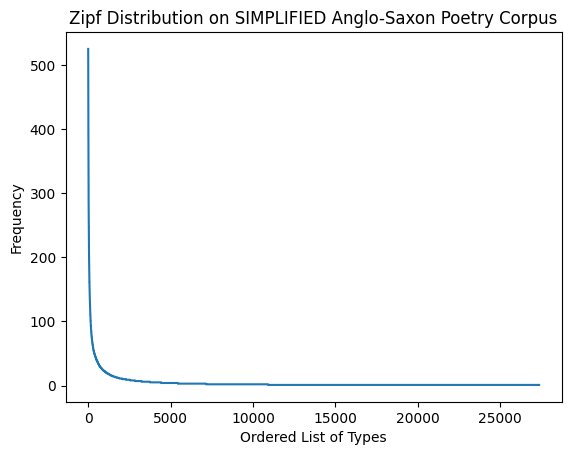

In [ ]:
#Checking the Simplified Corpus

#Provides the new word count on the simplified corpus
! wc Corpus/Simplified_Corpus.txt

print('-'*150)

#Creates a frequency list from the simplified corpus for comparison
with open('Corpus/Simplified_Corpus.txt', 'r') as corpus_file:
  simp_corpus = corpus_file.read()

simp_freqlist_corpus = {}

tokens = [token for token in simp_corpus.split()]

for token in tokens:
  if token not in simp_freqlist_corpus:
    simp_freqlist_corpus[token] = 1
  else:
    simp_freqlist_corpus[token] += 1

print(sorted(simp_freqlist_corpus.items(), key = lambda x : x[1], reverse = True))

print('-'*150)

#Graphs the Zipf Distribution on the simplified corpus
simp_ranked_corpus = {i: freq[1] for i, freq in enumerate(sorted(simp_freqlist_corpus.items(), key = lambda x : x[1], reverse = True))}

plt.plot(simp_ranked_corpus.keys(), simp_ranked_corpus.values())
plt.xlabel('Ordered List of Types')
plt.ylabel('Frequency')
plt.title('Zipf Distribution on SIMPLIFIED Anglo-Saxon Poetry Corpus')
plt.show()

###**Original Scraping of the Simplified Corpus**

In [ ]:
#Producing the Documents for Analysis (DONT RERUN)
r = re.compile(r'[^\w+]')

ex_lis = [token for token, freq in sorted(freqlist_corpus.items(), key = lambda x : x[1], reverse = True)[:31]] #creates a list of words to be excluded (see above)
ex_lis.append('ðe')

for title, url in corpus_dict.items():
  req = requests.get(url)
  source = req.text
  soup = BeautifulSoup(source)

  with open(f'Old English Documents/{title}.txt', 'w') as fout:
    try:
      text = [tag.get_text().strip().lower() for tag in soup.find_all('dd')] #pulls the text from the webpage, strips, and lowercases it

      joined_text = ' '.join(text) #joins together the fragments of texts into a single string

      clean_text = r.sub(' ', joined_text) #cleans the string of punctuation and all non-text elements

      tokenized_text = [token for token in clean_text.split() if token not in ex_lis] #appends a list with the text, as individual tokens, excluding the high-frequency words (as given by ex_lis)

      text_out = ' '.join(tokenized_text) #rejoins the tokens into a single string

      fout.write(text_out)

    except:
      print(title)

print('Operation Complete.')

Operation Complete.


###**Original Document-Term Matrix of the Simplified Corpus**

In [ ]:
#Creating and Filling a Doc2Term Matrix

#Populates two lists: docs (entire documents - for matrix), doc_titles (titles of documents - for IDs)
docs = []
doc_titles = []
for fil in glob.glob('/content/gdrive/MyDrive/Computational Linguistics/Final Project/Old English Documents/*.txt'):
  doc_titles.append(fil.split('/')[-1].strip('.txt'))

  with open(fil, 'r') as doc_in:
    temp_doc = doc_in.read()
    docs.append(temp_doc)

#Populates a dictionary with a frequency list, i.e. vocabulary of document corpus
vocab = {}
for doc in docs:
  for token in doc.split():
    if token not in vocab:
      vocab[token] = 1
    else:
      vocab[token] += 1

#Creates the dimensions of the matrix using the length of the vocabulary and that of the list of documents
mat = lil_matrix((len(docs), len(vocab)))

#Assigns IDs to each token (indexable with 'token_ids['term']') and to each document in the matrix (indexable with 'doc_ids['term']')
token_ids = {token: i for i, token in enumerate(vocab)}
doc_ids = {title: i for i, title in enumerate(doc_titles)}

#Populates the Matrix
for i, doc in enumerate(docs):
  for token in doc.split():
    mat[i, token_ids[token]] +=1

In [ ]:
#Matrix Checks
print('Doc2Term Matrix:')
print(mat.toarray())
print('-' * 50)

print(f'The shape of the matrix is {mat.toarray().shape}.')
print('-' * 50)

print('The column index of "drihten" is %d.'%token_ids['drihten'])
print('-' * 50)

print('The token "drihten" occurs %d times.'%mat[:, 157].sum())
print('-' * 50)

mat[:, 157].toarray() #column for 'drihten' (print only if necessary)

print('The token "drihten" is used in %d articles.'%mat[:, 157].nnz) #(non zeros)
print('-' * 50)

print(f'The row index of "Beowulf" is %d.'%doc_ids['Beowulf'])
print('-' * 50)

print('The row for Beowulf is:', mat[136, :].toarray())

Doc2Term Matrix:
[[21.  8. 18. ...  0.  0.  0.]
 [ 3.  4.  3. ...  0.  0.  0.]
 [ 2.  1.  5. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  1.  1.]]
--------------------------------------------------
The shape of the matrix is (347, 27105).
--------------------------------------------------
The column index of "drihten" is 157.
--------------------------------------------------
The token "drihten" occurs 540 times.
--------------------------------------------------
The token "drihten" is used in 135 articles.
--------------------------------------------------
The row index of "Beowulf" is 136.
--------------------------------------------------
The row for Beowulf is: [[10.  2. 10. ...  0.  0.  0.]]


In [ ]:
#Visualizing the Matrix with Pandas

#Converts the matrix into an array
mat_arr = mat.toarray()

#Creates lists of document and term IDs
doc_lab = []
for doc in doc_ids.keys():
  doc_lab.append(doc)

token_lab = []
for token in token_ids.keys():
  token_lab.append(token)
token_lab.insert(0, '') #necessary spacer for the labels

#Transforms the above lists into arrays
doc_arr = np.array(doc_lab) #(347,)
tok_arr = np.array(token_lab) #(27106,)

#Reshapes the arrays to add the necessary dimension for concatenation
doc_labels = np.reshape(doc_arr, (347, 1)) #(347, 1)
tok_labels = np.reshape(tok_arr, (1, 27106)) #(1, 27106)

#Adds the labels to the existing matrix
data_docs = np.concatenate([doc_labels, mat_arr], axis = 1)
final_data = np.concatenate([tok_labels, data_docs], axis = 0)

#Visualization
dataframe_corpus = pd.DataFrame(final_data)
dataframe_corpus

,0,1,2,3,4,5,6,7,8,9,...,27096,27097,27098,27099,27100,27101,27102,27103,27104,27105
0,,us,riht,micel,ðæt,we,rodera,weard,wereda,wuldorcining,...,awage,weorne,weter,anbre,litel,linsetcorn,miccli,lesse,handwurmes,hupeban
1,"Genesis A, B",21.0,8.0,18.0,1.0,29.0,4.0,20.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Exodus,3.0,4.0,3.0,0.0,2.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Daniel,2.0,1.0,5.0,0.0,10.0,1.0,22.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Christ and Satan,23.0,3.0,1.0,1.0,34.0,2.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,Metrical Charm 8: For a Swarm of Bees,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344,Metrical Charm 9: For Loss of Cattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345,Metrical Charm 10: For Loss of Cattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346,Metrical Charm 11: A Journey Charm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###**Original Principle Component Analysis (PCA) of the Simplified Corpus**

In [ ]:
#Transforming Matrix into Pandas Dataframe and Standardizing Results
mat_arr = mat.toarray()
mat_df = pd.DataFrame(mat_arr)

sd_df = StandardScaler().fit_transform(mat_df)
sd_df

array([[ 5.68465147, 11.89093866, 13.85860021, ..., -0.05376033,
        -0.05376033, -0.05376033],
       [ 0.55590193,  5.84528926,  2.13521095, ..., -0.05376033,
        -0.05376033, -0.05376033],
       [ 0.2709714 ,  1.31105221,  3.69832952, ..., -0.05376033,
        -0.05376033, -0.05376033],
       ...,
       [-0.29888966, -0.20036014, -0.2094669 , ..., -0.05376033,
        -0.05376033, -0.05376033],
       [-0.29888966, -0.20036014, -0.2094669 , ..., -0.05376033,
        -0.05376033, -0.05376033],
       [-0.29888966, -0.20036014, -0.2094669 , ..., 18.60107524,
        18.60107524, 18.60107524]])

In [ ]:
#Performing a PCA on the Corpus Dataframe
pca = PCA(n_components = 2)
pca_mat = pca.fit_transform(sd_df)

#Recreates the document labels (so as to not have to rerun the above dataframe to save RAM)
doc_lab = []
for doc in doc_ids.keys():
  doc_lab.append(doc)
doc_arr = np.array(doc_lab)
doclab_df = pd.DataFrame(doc_arr)

#Creates a dataframe from the PCA data
pca_df = pd.DataFrame(data = pca_mat, columns = ['Principle Component 1', 'Principle Component 2'])

final_df = pd.concat([doclab_df, pca_df], axis = 1)
final_df

,0,Principle Component 1,Principle Component 2
0,"Genesis A, B",303.554046,829.301707
1,Exodus,33.544732,23.544522
2,Daniel,36.678185,41.806574
3,Christ and Satan,28.128872,29.302070
4,Andreas,138.708098,122.931628
...,...,...,...
342,Metrical Charm 8: For a Swarm of Bees,-7.169598,-4.089739
343,Metrical Charm 9: For Loss of Cattle,-6.960168,-3.989593
344,Metrical Charm 10: For Loss of Cattle,-6.989158,-3.877034
345,Metrical Charm 11: A Journey Charm,-6.258211,-3.543494


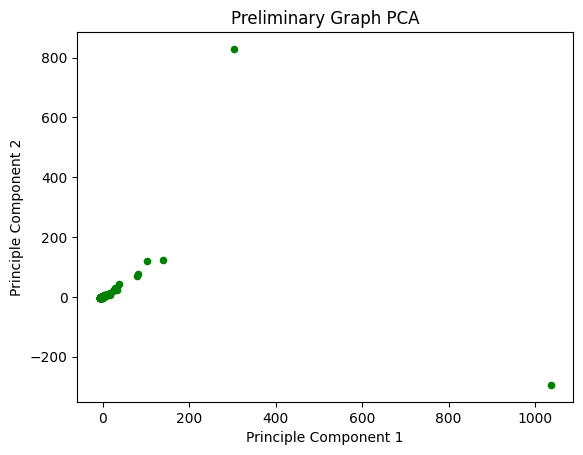

In [ ]:
#Initial Plotting of the PCA
final_df.plot.scatter(x = 'Principle Component 1', y = 'Principle Component 2', title = 'Preliminary Graph PCA', c = 'green')
plt.show()

Beowulf
Genesis A, B
0
136


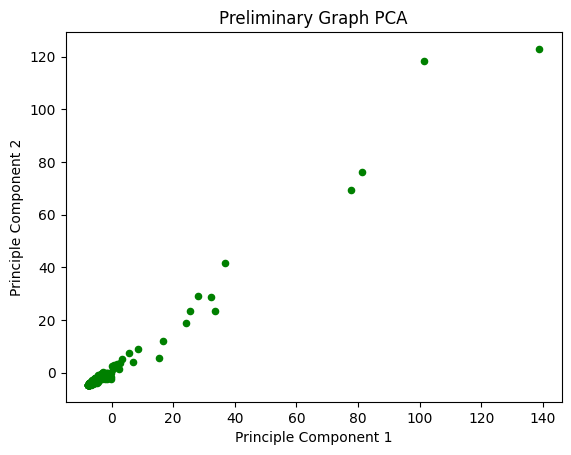

In [ ]:
#Temporarily Removing Outliers and Replotting
for i, x in enumerate(final_df['Principle Component 1']):
  if x > 1000:
    print(final_df[0][i])
  else:
    pass

for i, y in enumerate(final_df['Principle Component 2']):
  if y > 800:
    print(final_df[0][i])
  else:
    pass

for i, x in enumerate(final_df[0]):
  if x == 'Genesis A, B':
    print(i)

for i, x in enumerate(final_df[0]):
  if x == 'Beowulf':
    print(i)

final_df_nolong = final_df.drop(labels = [0, 136], axis = 0)

final_df_nolong.plot.scatter(x = 'Principle Component 1', y = 'Principle Component 2', title = 'Preliminary Graph PCA', c = 'green')
plt.show()

In [ ]:
#Explained Variance through PCA
print('The present PCA accounts for %g percent of the variance.'%(sum(pca.explained_variance_ratio_) * 100))

###RECOMMENDATIONS ARE FOR 85% OR HIGHER

The present PCA accounts for 21.8055 percent of the variance.


In [ ]:
for i, x in enumerate(final_df['Principle Component 1']):
  if 100 > x > 75:
    print(final_df[0][i])
  else:
    pass

for i, x in enumerate(final_df['Principle Component 1']):
  if 200 > x > 100:
    print(final_df[0][i])
  else:
    pass

Elene
Guthlac A, B
Andreas
Christ A, B, C


###**Original Latent Dirichlet Analysis (LDA) of the Simplified Corpus**

In [ ]:
docs = []
docids = {}
for i, fil in enumerate(glob.glob('/content/gdrive/MyDrive/Computational Linguistics/Final Project/Old English Documents/*.txt')):
  with open(fil, 'r') as doc_in:
    docs.append(doc_in.read().split())

  docids[fil.split('/')[-1].strip('.txt')] = i

In [ ]:
dictionary = corpora.Dictionary(docs) #gensim dictionary
doc_term_corp = [dictionary.doc2bow(poem) for poem in docs] #term doc freq, corpus

In [ ]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus = doc_term_corp, id2word = dictionary, num_topics = 5, random_state = 1, chunksize = 1000, passes = 50)

In [ ]:
lda_model.print_topics()

[(0,
  '0.010*"drihten" + 0.007*"ealle" + 0.005*"swylce" + 0.005*"min" + 0.004*"þin" + 0.004*"þine" + 0.004*"mine" + 0.004*"eac" + 0.004*"ær" + 0.004*"æt"'),
 (1,
  '0.008*"hie" + 0.003*"ac" + 0.003*"ðu" + 0.003*"for" + 0.003*"æfter" + 0.003*"under" + 0.003*"siððan" + 0.003*"wordum" + 0.003*"godes" + 0.003*"wearð"'),
 (2,
  '0.006*"sceal" + 0.005*"bið" + 0.005*"we" + 0.004*"ac" + 0.004*"us" + 0.003*"ær" + 0.003*"mec" + 0.003*"hy" + 0.003*"hine" + 0.003*"godes"'),
 (3,
  '0.004*"wið" + 0.004*"hine" + 0.004*"heo" + 0.003*"gif" + 0.003*"ac" + 0.003*"text" + 0.003*"ðæt" + 0.003*"mæg" + 0.003*"ðonne" + 0.003*"bið"'),
 (4,
  '0.006*"ðu" + 0.004*"ær" + 0.004*"bið" + 0.003*"for" + 0.003*"hio" + 0.003*"eorðan" + 0.003*"hwæt" + 0.003*"eac" + 0.003*"ge" + 0.003*"æt"')]

##**Work Cells**

Cells used to build the framework for the project above. Not a part of the project.

In [ ]:
text = 'heck heck heck an and twentigoþa god helpe sumes mannes þæs þe ac heck heck heck'
exclude_dicter = {'god': 'helpe sumes mannes', 'an': 'and twentigoþa', 'ac': [], 'þæs' : 'þe'}

for token, token2, token3, token4 in zip(text.split(), text.split()[1:], text.split()[2:], text.split()[3:]):
  if token in exclude_dicter:
    if exclude_dicter[token] != []:
      if token2 + ' ' + token3 + ' ' + token4 in exclude_dict[token]:
        print(token, token2, token3, token4)
      elif token2 + ' ' + token3 in exclude_dict[token]:
        print(token, token2, token3)
      elif token2 in exclude_dicter[token]:
        print(token, token2)
    else:
      print(token)

# for token, token2, token3, token4 in zip(text.split(), text.split()[1:], text.split()[2:], text.split()[3:]):
#   if token in exclude_dicter:
#     if exclude_dicter[token] != []:
#       if token2 in exclude_dicter[token]:
#         print(token, token2)
#       elif token2 and token3 in exclude_dicter[token]:
#         if len(token2.split() + token3.split()) == len(exclude_dicter[token].split()):
#           print(token, token2, token3)
#         elif len(token2.split() + token3.split() + token4.split()) == len(exclude_dicter[token].split()):
#           print(token, token2, token3, token4)
#     else:
#       print(token)


# for key, value in exclude_dict.items():
#   if value != []:
#     print(key, value)

an and twentigoþa
god helpe sumes mannes
þæs þe
ac


PCA Problem Solving:

In [ ]:
#TEST 1: STANDARDIZING BY TAKING REDUCING THE MAGNITUDE THROUGH A LOGARITHM
mat_arr = mat.toarray() #matrix to array
log_arr = np.log(mat_arr, out = np.zeros_like(mat_arr), where=(mat_arr != 0)) #applies the natural log to all non zero numbers
mat_df_log = pd.DataFrame(log_arr) #transforms to dataframe

sd_df_log = StandardScaler().fit_transform(mat_df_log) #standardizes for PCA

pca_log = PCA(n_components = 2) #creates instance of PCA, 2 dimensions
pca_mat_log = pca_log.fit_transform(sd_df_log) #performs PCA to reduce to 2 dimensions

doc_lab = [doc for doc in doc_ids.keys()]
doc_arr = np.array(doc_lab)
doclab_df = pd.DataFrame(doc_arr) #creates dataframe with document labels (for visualization)

pca_df_log = pd.DataFrame(data = pca_mat_log, columns = ['Principle Component 1', 'Principle Component 2']) #transforms PCA results to dataframe

final_df_log = pd.concat([doclab_df, pca_df_log], axis = 1) #adds labels to PCA dataframe
final_df_log_nolong = final_df_log.drop(labels = [0, 136], axis = 0) #drops outliers

print('The present PCA accounts for %g percent of the variance.'%(sum(pca_log.explained_variance_ratio_) * 100))
final_df_log
final_df_log_nolong

The present PCA accounts for 35.827 percent of the variance.


,0,Principle Component 1,Principle Component 2
1,Exodus,23.303189,4.655946
2,Daniel,37.130960,17.141424
3,Christ and Satan,31.400512,14.636234
4,Andreas,119.791137,35.079617
5,The Fates of the Apostles,-2.082769,-0.546088
...,...,...,...
342,Metrical Charm 8: For a Swarm of Bees,-4.880746,-1.187591
343,Metrical Charm 9: For Loss of Cattle,-4.679157,-0.943469
344,Metrical Charm 10: For Loss of Cattle,-4.805403,-1.156403
345,Metrical Charm 11: A Journey Charm,-4.307442,-1.123977


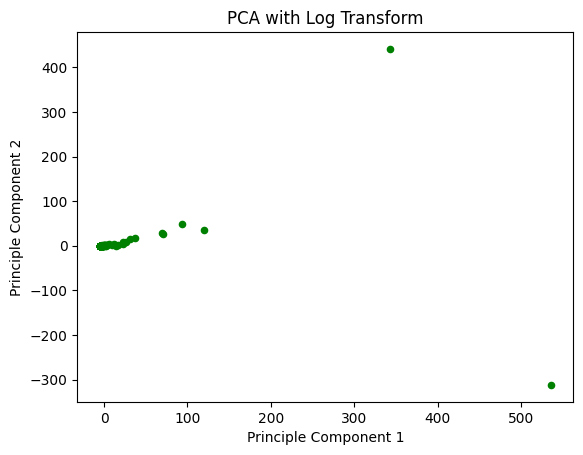

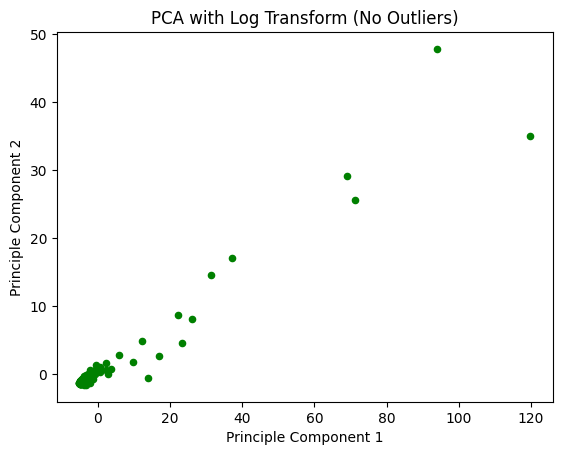

In [ ]:
#Graphing Results
final_df_log.plot.scatter(x = 'Principle Component 1', y = 'Principle Component 2', title = 'PCA with Log Transform', c = 'green')
plt.show()

final_df_log_nolong.plot.scatter(x = 'Principle Component 1', y = 'Principle Component 2', title = 'PCA with Log Transform (No Outliers)', c = 'green')
plt.show()

In [ ]:
#TEST 2: STANDARDIZING BY DOCUMENT LENGTH (DIVIDING EACH ROW BY LENGTH OF DOCUMENT IN TOKENS)
docs = []
for fil in glob.glob('/content/gdrive/MyDrive/Computational Linguistics/Final Project/Old English Documents/*.txt'):
  with open(fil, 'r') as doc_in:
    temp_doc = doc_in.read()
    docs.append(temp_doc) #recreating instance of list housing all document content (so as to not run prior cell)

mat_arr = mat.toarray() #matrix to array

doc_len = [len(x.split()) for x in docs] #creates list of document lengths in tokens

temp_arr = [row/doc_len[i] for i, row in enumerate(mat_arr)] #creates temporary list housing normalized array

norm_arr = np.asarray(temp_arr) #transforms list to array
mat_df_norm = pd.DataFrame(norm_arr) #creates dataframe from array

sd_df_norm = StandardScaler().fit_transform(mat_df_norm) #standardizes for PCA

pca_norm = PCA(n_components = 2) #creates instance of PCA, 2 dimensions
pca_mat_norm = pca_norm.fit_transform(sd_df_norm) #performs PCA to reduce to 2 dimensions

doc_lab = [doc for doc in doc_ids.keys()]
doc_arr = np.array(doc_lab)
doclab_df = pd.DataFrame(doc_arr) #creates dataframe with document labels (for visualization)

pca_df_norm = pd.DataFrame(data = pca_mat_norm, columns = ['Principle Component 1', 'Principle Component 2']) #transforms PCA results to dataframe

final_df_norm = pd.concat([doclab_df, pca_df_norm], axis = 1) #adds labels to PCA dataframe
final_df_norm_nolong = final_df_norm.drop(labels = [0, 136], axis = 0) #drops outliers

print('The present PCA accounts for %g percent of the variance.'%(sum(pca_norm.explained_variance_ratio_) * 100))
final_df_norm_nolong
final_df_norm

The present PCA accounts for 14.734 percent of the variance.


,0,Principle Component 1,Principle Component 2
0,"Genesis A, B",44.953141,729.702878
1,Exodus,5.099921,8.842520
2,Daniel,3.135828,9.589368
3,Christ and Satan,0.787959,4.060828
4,Andreas,29.712445,43.238521
...,...,...,...
342,Metrical Charm 8: For a Swarm of Bees,-3.153136,-2.520568
343,Metrical Charm 9: For Loss of Cattle,-3.134580,-2.553082
344,Metrical Charm 10: For Loss of Cattle,-3.156185,-2.510943
345,Metrical Charm 11: A Journey Charm,-3.141912,-2.488530


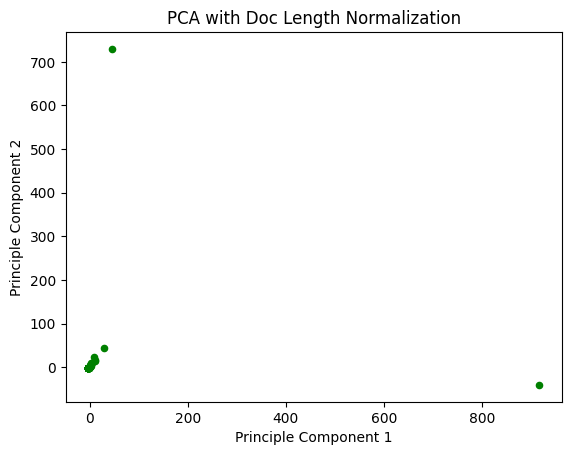

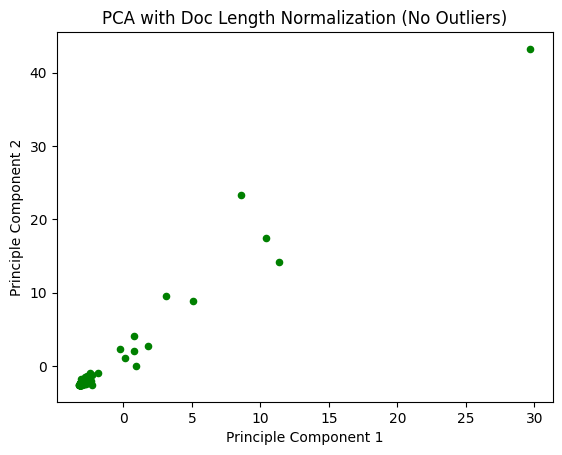

In [ ]:
#Graphing Results
final_df_norm.plot.scatter(x = 'Principle Component 1', y = 'Principle Component 2', title = 'PCA with Doc Length Normalization', c = 'green')
plt.show()

final_df_norm_nolong.plot.scatter(x = 'Principle Component 1', y = 'Principle Component 2', title = 'PCA with Doc Length Normalization (No Outliers)', c = 'green')
plt.show()

In [ ]:
#WORK CELL GRAB AND CLEAN TEXT
url = 'https://sacred-texts.com/neu/ascp/a03_01.htm'

r = re.compile(r'[^\w+]') #[^\?\w+\d*]

req = requests.get(url)
source = req.text
soup = BeautifulSoup(source)


text = [tag.get_text().strip().lower() for tag in soup.find_all('dd')]

joined_text = ' '.join(text)

clean = r.sub(' ', joined_text)

tokenized_text = []
for token in clean.split():
  if token not in ex_lis:
    tokenized_text.append(token)

fout = ' '.join(tokenized_text)
fout

'cyninge ðu eart weallstan wyrhtan iu wiðwurpon weorce wel geriseð heafod sie healle mærre gesomnige side weallas fæste gefoge flint unbræcne geond eorðb g eall eagna gesihþe wundrien worlde wuldres ealdor gesweotula searocræft þin sylfes weorc soðfæst sigorbeorht sona forlæt weall wið wealle weorce þearf cræftga cume cyning sylfa gebete gebrosnad hus under hrofe hra gescop leomo læmena sceal liffrea þone wergan heap wraþum ahreddan earme from egsan oft dyde eala reccend riht cyning locan healdeð lif ontyneð eadga upwegas oþrum forwyrneð wlitigan wilsiþes gif weorc deag huru we for þearfe þas word sprecað m giað þone mon gescop ete ceose weorðan cearfulra þing we carcerne sittað sorgende sunnan wenað hwonne us liffrea leoht ontyne weorðe ussum mode mundboran tydre gewitt tire bewinde gedo usic wyrðe wuldre forlet we heanlice hweorfan sceoldan þis enge lond eðle bescyrede forþon secgan mæg ðe soð spriceð ahredde forhwyrfed frumcyn fira seo fæmne geong mægð manes leas meder geceas geword

In [ ]:
docs = []
doc_titles = []
for fil in glob.glob('/content/gdrive/MyDrive/Computational Linguistics/Final Project/Old English Documents/*.txt'):
  doc_titles.append(fil.split('/')[-1].strip('.txt'))

doc_titles

['Genesis A, B',
 'Exodus',
 'Daniel',
 'Christ and Satan',
 'Andreas',
 'The Fates of the Apostles',
 'Soul and Body I',
 'Homiletic Fragment I',
 'Dream of the Rood',
 'Elene',
 'Christ A, B, C',
 'Guthlac A, B',
 'Azarias',
 'The Phoeni',
 'Juliana',
 'The Wanderer',
 'The Gifts of Men',
 'Precepts',
 'The Seafarer',
 'Vainglory',
 'Widsith',
 'The Fortunes of Men',
 'Maxims I',
 'The Order of the World',
 'The Riming Poem',
 'The Panther',
 'The Whale',
 'The Partridge',
 'Soul and Body II',
 'Deor',
 'Wulf and Eadwacer',
 'Riddle 1',
 'Riddle 2',
 'Riddle 3',
 'Riddle 4',
 'Riddle 5',
 'Riddle 6',
 'Riddle 7',
 'Riddle 8',
 'Riddle 9',
 'Riddle 10',
 'Riddle 11',
 'Riddle 12',
 'Riddle 13',
 'Riddle 14',
 'Riddle 15',
 'Riddle 16',
 'Riddle 17',
 'Riddle 18',
 'Riddle 19',
 'Riddle 20',
 'Riddle 21',
 'Riddle 22',
 'Riddle 23',
 'Riddle 24',
 'Riddle 25',
 'Riddle 26',
 'Riddle 27',
 'Riddle 28',
 'Riddle 29',
 'Riddle 30',
 'Riddle 31',
 'Riddle 32',
 'Riddle 33',
 'Riddle 34',
 

In [ ]:
docs = []
for fil in glob.glob('/content/gdrive/MyDrive/Computational Linguistics/Final Project/Old English Documents/*.txt'):
  with open(fil, 'r') as doc_in:
    temp_doc = doc_in.read()
    docs.append(temp_doc)

yes = []
for x in docs:
  yes.append(len(x.split()))

sum(yes)

In [ ]:
prac = lil_matrix((2,2))
prac[0,0] = 10
prac[1,1] = 500
prac_arr = prac.toarray()

lis = [40, 4000]

t = []
for i, row in enumerate(prac_arr):
  t.append(row/lis[i])

np.asarray(t).shape

(2, 2)